## Code required to create Figure 4
Entire notebook takes ~35 minutes to run on Intel i7-10750 using > 10GB RAM

Note: figure 4 is towards the end of the notebook

In [560]:
import collections
import datetime
import glob
import re
import os
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors
import matplotlib.transforms
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sns.set_context('paper')

# Functions to load CMIP6 runs

In [2]:
def make_combined_df_from_data_paths(data_paths, ignored_data_paths, date_format="\d{2}:\d{2}:\d{2}", data_name=None):
    first_ind = 0 ## FIX: what if first value is not enough days (I am leaving for now, but could use recursion)
    df = pd.read_csv(data_paths[first_ind])
    df = remove_unwanted_columns(df)
    wrote_data_name = False
    if not data_name:
        data_name = os.path.split(data_paths[first_ind])[-1].split("_")[2] + "_" + os.path.split(data_paths[first_ind])[-1].split("_")[4]
        wrote_data_name = True
    df.columns = ["time", data_name]
    # remove time from date
    df['time'] = df['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    for f in data_paths[first_ind+1:]:
        if f in ignored_data_paths:
            # print(f)
            continue
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2] + "_" + os.path.split(f)[-1].split("_")[4]
        else:
            current_data_name = data_name
        current.columns = ["time", current_data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
        df = df.merge(current, how='outer', on='time')
    df = df.set_index('time')
    df = df.sort_index()
    return df


def make_combined_df_from_data_paths_for_bracegirdle(data_paths, ignored_data_paths, data_name=None):
    first_ind = 0 ## FIX: what if first value is not enough days (I am leaving for now, but could use recursion)
    df = pd.read_csv(data_paths[first_ind])
    df = remove_unwanted_columns(df)
    wrote_data_name = False
    if not data_name:
        data_name = os.path.split(data_paths[first_ind])[-1].split("_")[2] + "_" + os.path.split(data_paths[first_ind])[-1].split("_")[4]
        wrote_data_name = True
    df.columns = ["year", data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
    # remove time from date
    for f in data_paths[first_ind+1:]:
        if f in ignored_data_paths:
            continue
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2] + "_" + os.path.split(f)[-1].split("_")[4]
        else:
            current_data_name = data_name
        current.columns = ["year", current_data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        df = df.merge(current, how='outer', on='year')
    df = df.set_index('year')
    df = df.sort_index()
    return df


def remove_unwanted_columns(data):
    for col in data.columns:
        if col in COLS_TO_REMOVE:
            data = data.drop(col, axis=1)
    return data

# Globals

In [3]:
METRIC_NAMES = ["Woollings et al. 2010", "Barnes & Polvani 2013", "Grise & Polvani 2014", \
                "Barnes & Simpson 2017", "Bracegirdle et al. 2018", "Zappa et al. 2018", "Kerr et al. 2020"]
METRIC_DATA_NAMES = ['Woollings2010_NorthPacific', 'BarnesPolvani2013_NorthPacific',\
                     'BarnesSimpson2017_NorthPacific','GrisePolvani2017_NorthPacific', 'Bracegirdle2018_NorthPacific',\
                     'Zappa2018_NorthPacific', 'Kerr2020_NorthPacific'] # , "Barnes & Polvani 2015"
METRIC_SHORTHAND = ["W10", "BP13", "BS17", "GP17", "B18", "Z18", "K20"] # "BP15",

In [4]:
METRIC_LABEL_RENAMER = dict(zip(METRIC_DATA_NAMES, METRIC_NAMES))
METRIC_SHORTHAND_LABEL_RENAMER = dict(zip(METRIC_NAMES, METRIC_SHORTHAND))

In [5]:
ALL_MONTHS = ["January", "February", "March", "April", "May", "June",\
              "July", "August", "September", "October", "November", "December"]
ALL_MONTHS_SHORT = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [6]:
MONTH_DICT = dict(zip(np.arange(1, 13), ALL_MONTHS))
MONTH_SHORT_DICT = dict(zip(np.arange(1, 13), ALL_MONTHS_SHORT))

# Load CMIP6 SSP5-8.5 

In [7]:
PROJ_START_DATE = "2070-01-01"
PROJ_END_DATE = "2099-12-31"
PERIOD_NUMBER_OF_DAYS = (pd.to_datetime(PROJ_END_DATE) - pd.to_datetime(PROJ_START_DATE)).days
MISSING_NUM_DAYS_THRESHOLD = 0.05 ## only allow for up to 5% less duration in data 

In [8]:
CMIP6_2070to2100_dir = "/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_AllScenarioMIP_daily_runs/outputs/ua_day*ssp585*"

In [9]:
metric_names = ["Woollings et al. 2010", "Barnes & Polvani 2013", \
                "Barnes & Simpson 2017", "Grise & Polvani 2017", "Bracegirdle et al. 2018", \
                "Zappa et al. 2018", "Kerr et al. 2020"] # , "Barnes & Polvani 2015"

COLS_TO_REMOVE = ["10_day_average", "plev"]

In [10]:
print("Num of North Pacific files:", len(glob.glob(CMIP6_2070to2100_dir + "North Pacific" + "*")))

Num of North Pacific files: 870


In [11]:
%%time
## takes 8 seconds on Intel i7-10750 
time_ranges = []
failed_data_paths = []
data_paths_not_enough_days = []

date_format="\d{2}:\d{2}:\d{2}"
for file_path in glob.glob(CMIP6_2070to2100_dir):
    try:
        current = pd.read_csv(file_path, header=0)
    except Exception as e:
        print(e)
        print(file_path)
        continue
    for col in COLS_TO_REMOVE:
        try:
            current.drop(col, inplace=True, axis=1)
        except:
            pass
    try:
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    except KeyError as e:
        ## we expect bracegirlde to fail this time formatting (as it is an annual metric) 
        assert str(e) == "'time'", f"failed for another reason: {e}"
        failed_data_paths.append(file_path)
        continue
    first_time = current['time'].min()
    last_time = current['time'].max()
    current_data_period_in_days = (pd.to_datetime(last_time) - pd.to_datetime(first_time)).days
    ## check there is enough days
    if (PERIOD_NUMBER_OF_DAYS * MISSING_NUM_DAYS_THRESHOLD) < current_data_period_in_days:
        time_ranges.append(str(first_time)+'to'+str(last_time))
    else:
        data_paths_not_enough_days.append(file_path)

CPU times: user 29.3 s, sys: 998 ms, total: 30.3 s
Wall time: 30.5 s


#### check dates look ok

In [12]:
collections.Counter(time_ranges)

Counter({'2015-01-01to2100-12-31': 559,
         '2015-01-01to2100-12-30': 112,
         '2015-01-01to2100-12-22': 32,
         '2015-01-01to2100-12-21': 16,
         '2015-01-01to2099-12-30': 14,
         '2041-01-01to2070-12-31': 7,
         '2019-01-01to2100-12-31': 7,
         '2020-01-01to2099-12-31': 7,
         '2071-01-01to2100-12-31': 6,
         '2015-01-01to2099-12-31': 5,
         '2015-01-01to2099-12-21': 2,
         '2020-01-01to2099-12-22': 1,
         '2041-01-01to2100-12-31': 1,
         '2041-01-01to2070-12-25': 1,
         '2019-01-01to2100-12-22': 1,
         '2015-01-01to2099-12-26': 1,
         '2071-01-01to2100-12-25': 1})

In [13]:
len(data_paths_not_enough_days)

0

In [14]:
## check all failures are bracegirdle (because this is an annual metric)
all(['Bracegirdle et al. 2018' in fn for fn in failed_data_paths]), len(failed_data_paths)

(True, 97)

## create dataset 

In [15]:
## only one problematic dataset NESM3_1i1r1p1f
bracegirlde_ignore_data_paths = ['/home/thomaskeel/Documents/PhD/JASMIN experiments/CMIP6_2070to2100_NPAC runs/ua_day_NESM3_ssp585_r1i1p1f1_gnBracegirlde et al. 2018 North Pacific.csv'] 

In [16]:
%%time
## takes 10 seconds on Intel i7-10750 
all_df_npac_future_dataset = {}
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_future_dataset[metric] = make_combined_df_from_data_paths_for_bracegirdle(glob.glob(CMIP6_2070to2100_dir + metric + "*" + "North Pacific" + "*"),\
                                                                                             ignored_data_paths=bracegirlde_ignore_data_paths)
        continue
    all_df_npac_future_dataset[metric] = make_combined_df_from_data_paths(glob.glob(CMIP6_2070to2100_dir + metric + "*" + "North Pacific" + "*"),\
                                                                          ignored_data_paths=data_paths_not_enough_days)


CPU times: user 27.4 s, sys: 193 ms, total: 27.6 s
Wall time: 27.6 s


In [17]:
all_df_npac_future_dataset['Zappa et al. 2018'].columns

Index(['MIROC6_r3i1p1f1', 'GFDL-CM4_r1i1p1f1', 'UKESM1-0-LL_r2i1p1f2',
       'UKESM1-0-LL_r15i1p1f2', 'CanESM5_r3i1p2f1', 'NorESM2-LM_r1i1p1f1',
       'HadGEM3-GC31-LL_r1i1p1f3', 'CanESM5_r4i1p2f1', 'INM-CM4-8_r1i1p1f1',
       'HadGEM3-GC31-LL_r3i1p1f3', 'UKESM1-0-LL_r1i1p1f2', 'CanESM5_r7i1p2f1',
       'ACCESS-CM2_r1i1p1f1', 'EC-Earth3-Veg-LR_r1i1p1f1',
       'BCC-CSM2-MR_r1i1p1f1', 'UKESM1-0-LL_r14i1p1f2', 'CanESM5_r5i1p2f1',
       'MIROC-ES2L_r7i1p1f2', 'UKESM1-0-LL_r8i1p1f2', 'CESM2-WACCM_r2i1p1f1',
       'CanESM5_r2i1p1f1', 'MIROC-ES2L_r1i1p1f2', 'INM-CM5-0_r1i1p1f1',
       'CanESM5_r7i1p1f1', 'CanESM5_r8i1p1f1', 'MIROC-ES2L_r3i1p1f2',
       'CanESM5_r9i1p2f1', 'NESM3_r2i1p1f1', 'CESM2-WACCM_r1i1p1f1',
       'MIROC-ES2L_r10i1p1f2', 'CNRM-CM6-1_r1i1p1f2', 'MPI-ESM1-2-LR_r2i1p1f1',
       'CanESM5_r8i1p2f1', 'MPI-ESM1-2-LR_r9i1p1f1', 'CanESM5_r3i1p1f1',
       'IITM-ESM_r1i1p1f1', 'IPSL-CM6A-LR_r1i1p1f1', 'CMCC-CM2-SR5_r1i1p1f1',
       'CNRM-CM6-1_r3i1p1f2', 'MPI-ESM1-2-H

### cleaning data
For some reason 'IITM-ESM_r1i1p1f1' does not want to run for W10 and BP13

In [18]:
%%time
## takes ~200 milliseconds on Intel i7-10750 
## rerun above 2 cell if you have a problem with Bracegirlde et al. 2018
START_YEAR = PROJ_START_DATE[:4] # 2070
END_YEAR = PROJ_END_DATE[:4] # 2099
FREQ = 'd'
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_future_dataset[metric].index = pd.date_range(start=START_YEAR, freq="y", periods=len(all_df_npac_future_dataset[metric]))
        all_df_npac_future_dataset[metric].index = all_df_npac_future_dataset[metric].index.rename('time')
    all_df_npac_future_dataset[metric].index = pd.to_datetime(all_df_npac_future_dataset[metric].index, errors='coerce')
    all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].groupby(pd.Grouper(freq=FREQ)).mean()
    all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric][START_YEAR: END_YEAR]
    if 'IITM-ESM_r1i1p1f1' in all_df_npac_future_dataset[metric].columns:
        all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].drop('IITM-ESM_r1i1p1f1', axis=1)
        print('removed IITM-ESM_r1i1p1f1')
    

removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
CPU times: user 371 ms, sys: 108 ms, total: 479 ms
Wall time: 479 ms


In [19]:
print(all_df_npac_future_dataset['Woollings et al. 2010'].columns.nunique() == len(all_df_npac_future_dataset['Woollings et al. 2010'].columns))
print(all_df_npac_future_dataset['Woollings et al. 2010'].columns.nunique() == len(all_df_npac_future_dataset['Kerr et al. 2020'].columns))

True
True


<Axes: xlabel='time'>

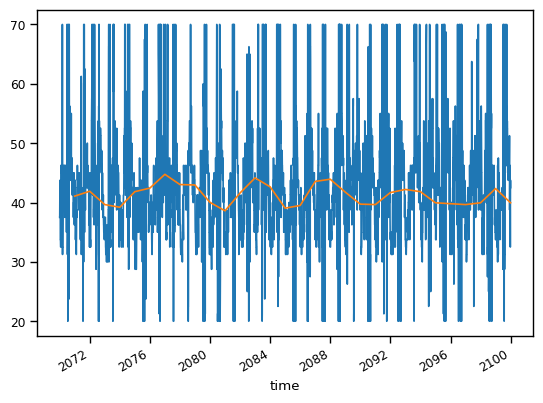

In [20]:
all_df_npac_future_dataset['Woollings et al. 2010']['HadGEM3-GC31-LL_r1i1p1f3'].dropna().plot()
all_df_npac_future_dataset['Bracegirdle et al. 2018']['HadGEM3-GC31-LL_r1i1p1f3'].dropna().plot()

In [21]:
len(all_df_npac_future_dataset['Woollings et al. 2010'].columns), len(all_df_npac_future_dataset['Barnes & Simpson 2017'].columns)

(96, 96)

#### view ensembles

In [22]:
collections.Counter([row.split('_r')[0] for row in all_df_npac_future_dataset['Woollings et al. 2010'].columns])

Counter({'CanESM5': 20,
         'MIROC-ES2L': 10,
         'MPI-ESM1-2-LR': 9,
         'UKESM1-0-LL': 7,
         'CNRM-CM6-1': 6,
         'HadGEM3-GC31-LL': 4,
         'HadGEM3-GC31-MM': 4,
         'IPSL-CM6A-LR': 3,
         'KACE-1-0-G': 3,
         'MIROC6': 3,
         'CESM2-WACCM': 3,
         'CNRM-ESM2-1': 2,
         'NESM3': 2,
         'ACCESS-ESM1-5': 2,
         'CMCC-ESM2': 1,
         'EC-Earth3-Veg-LR': 1,
         'NorESM2-LM': 1,
         'NorESM2-MM': 1,
         'EC-Earth3': 1,
         'MRI-ESM2-0': 1,
         'MPI-ESM1-2-HR': 1,
         'ACCESS-CM2': 1,
         'TaiESM1': 1,
         'EC-Earth3-CC': 1,
         'BCC-CSM2-MR': 1,
         'CMCC-CM2-SR5': 1,
         'INM-CM4-8': 1,
         'INM-CM5-0': 1,
         'FGOALS-g3': 1,
         'EC-Earth3-Veg': 1,
         'AWI-CM-1-1-MR': 1,
         'GFDL-CM4': 1})

In [23]:
# sorted(all_df_npac_future_dataset['Woollings et al. 2010'].columns, key=lambda row: row.split('_')[0])

# Load CMIP6 Historical

In [24]:
HIST_START_DATE = "1985-01-01"
HIST_END_DATE = "2015-12-31"
PERIOD_NUMBER_OF_DAYS = (pd.to_datetime(HIST_END_DATE) - pd.to_datetime(HIST_START_DATE)).days
MISSING_NUM_DAYS_THRESHOLD = 0.05 ## only allow for up to 5% less duration in data 

In [25]:
CMIP6_Historical_dir = "/home/thomaskeel/Documents/PhD/JASMIN experiments/CMIP6_Historical_NPAC runs/outputs/ua_day*"

In [26]:
metric_names = ["Woollings et al. 2010", "Barnes & Polvani 2013", \
                "Barnes & Simpson 2017", "Grise & Polvani 2017", "Bracegirdle et al. 2018", \
                "Zappa et al. 2018", "Kerr et al. 2020"] #, "Barnes & Polvani 2015"
COLS_TO_REMOVE = ["10_day_average", "plev"]

region = "North Pacific"

In [27]:
print(region, len(glob.glob(CMIP6_Historical_dir + region + "*")))

North Pacific 1483


In [28]:
%%time
## takes ~65 seconds on Intel i7-10750 

time_ranges = []
failed_data_paths = []
data_paths_not_enough_days = []
date_format="\d{2}:\d{2}:\d{2}"
for file_path in glob.glob(CMIP6_Historical_dir):
    try:
        current = pd.read_csv(file_path, header=0)
    except Exception as e:
        print(e)
        print(file_path)
        continue
    for col in COLS_TO_REMOVE:
        try:
            current.drop(col, inplace=True, axis=1)
        except:
            pass
    try:
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    except Exception as e:
#         print(e)
        failed_data_paths.append(file_path)
        continue
    first_time = current['time'].min()
    last_time = current['time'].max()
    current_data_period_in_days = (pd.to_datetime(last_time) - pd.to_datetime(first_time)).days
    ## check there is enough days
    if (PERIOD_NUMBER_OF_DAYS * MISSING_NUM_DAYS_THRESHOLD) < current_data_period_in_days:
        time_ranges.append(str(first_time)+'to'+str(last_time))
    else:
        data_paths_not_enough_days.append(file_path)

CPU times: user 43.2 s, sys: 393 ms, total: 43.5 s
Wall time: 44 s


In [29]:
collections.Counter(time_ranges)

Counter({'1950-01-01to2014-12-31': 953,
         '1950-01-01to2014-12-30': 189,
         '1950-01-01to2015-01-01': 84,
         '1950-01-01to2014-12-27': 49,
         '1950-01-01to2014-12-21': 27,
         '1950-01-02to2014-12-31': 7,
         '1950-01-01to2015-12-31': 7,
         '1950-01-02to2014-12-28': 1,
         '1950-01-01to2015-12-22': 1})

In [30]:
len(data_paths_not_enough_days)

0

In [31]:
## check all failures are bracegirdle (because this is an annual metric)
all(['Bracegirdle et al. 2018' in fn for fn in failed_data_paths]), len(failed_data_paths)

(True, 165)

In [32]:
%%time
## takes ~35 seconds on Intel i7-10750 
all_df_npac_hist_dataset = {}
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_hist_dataset[metric] = make_combined_df_from_data_paths_for_bracegirdle(glob.glob(CMIP6_Historical_dir + metric + "*" + "North Pacific" + "*"),
                                                                                           ignored_data_paths=[])
        continue
    all_df_npac_hist_dataset[metric] = make_combined_df_from_data_paths(glob.glob(CMIP6_Historical_dir + metric + "*" + "North Pacific" + "*"),
                                                                       ignored_data_paths=data_paths_not_enough_days)


CPU times: user 42.9 s, sys: 165 ms, total: 43.1 s
Wall time: 43.2 s


In [33]:
all_df_npac_hist_dataset['Woollings et al. 2010'].columns

Index(['ACCESS-CM2_r1i1p1f1', 'ACCESS-ESM1-5_r32i1p1f1',
       'IPSL-CM6A-LR_r2i1p1f1', 'MIROC-ES2L_r5i1p1f2', 'CNRM-CM6-1_r8i1p1f2',
       'CESM2_r5i1p1f1', 'CNRM-CM6-1_r4i1p1f2', 'BCC-CSM2-MR_r3i1p1f1',
       'HadGEM3-GC31-MM_r1i1p1f3', 'MRI-ESM2-0_r5i1p1f1',
       ...
       'GFDL-CM4_r1i1p1f1', 'CanESM5_r1i1p2f1', 'UKESM1-0-LL_r17i1p1f2',
       'CanESM5_r8i1p2f1', 'ACCESS-ESM1-5_r21i1p1f1',
       'ACCESS-ESM1-5_r17i1p1f1', 'IPSL-CM6A-LR_r5i1p1f1',
       'INM-CM4-8_r1i1p1f1', 'IPSL-CM6A-LR_r6i1p1f1', 'UKESM1-0-LL_r15i1p1f2'],
      dtype='object', length=164)

In [34]:
set(all_df_npac_hist_dataset['Barnes & Simpson 2017'].columns).difference(set(all_df_npac_hist_dataset['Woollings et al. 2010'].columns))

{'IITM-ESM_r1i1p1f1'}

In [35]:
%%time
## takes ~600 milliseconds on Intel i7-10750 
## rerun above 2 cell if you have a problem with Bracegirlde et al. 2018
START_YEAR = HIST_START_DATE[:4] # "1950"
END_YEAR = HIST_END_DATE[:4] # "2015"
FREQ = 'd'
for metric in metric_names:
    # print(metric)
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_hist_dataset[metric].index = pd.date_range(start="1950", freq="y", periods=len(all_df_npac_hist_dataset[metric])) # NOTE: START YEAR HARD CODED
        all_df_npac_hist_dataset[metric].index = all_df_npac_hist_dataset[metric].index.rename('time')
    all_df_npac_hist_dataset[metric].index = pd.to_datetime(all_df_npac_hist_dataset[metric].index, errors='coerce')
    all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].groupby(pd.Grouper(freq=FREQ)).mean()
    all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric][START_YEAR: END_YEAR]
    if 'IITM-ESM_r1i1p1f1' in all_df_npac_hist_dataset[metric].columns:
        all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].drop('IITM-ESM_r1i1p1f1', axis=1)
        print('removed IITM-ESM_r1i1p1f1')

removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
CPU times: user 349 ms, sys: 168 ms, total: 517 ms
Wall time: 516 ms


In [36]:
len(all_df_npac_hist_dataset['Woollings et al. 2010'].columns), len(all_df_npac_hist_dataset['Barnes & Simpson 2017'].columns)

(164, 164)

In [37]:
collections.Counter([row.split('_r')[0] for row in all_df_npac_hist_dataset['Woollings et al. 2010'].columns])

Counter({'ACCESS-ESM1-5': 37,
         'CanESM5': 19,
         'UKESM1-0-LL': 17,
         'CNRM-CM6-1': 10,
         'IPSL-CM6A-LR': 9,
         'CESM2': 8,
         'MIROC-ES2L': 7,
         'MRI-ESM2-0': 5,
         'CNRM-ESM2-1': 5,
         'HadGEM3-GC31-LL': 5,
         'HadGEM3-GC31-MM': 4,
         'CESM2-WACCM': 3,
         'BCC-ESM1': 3,
         'BCC-CSM2-MR': 2,
         'GISS-E2-1-G': 2,
         'ACCESS-CM2': 1,
         'EC-Earth3-AerChem': 1,
         'TaiESM1': 1,
         'FGOALS-g3': 1,
         'MPI-ESM-1-2-HAM': 1,
         'KACE-1-0-G': 1,
         'CMCC-ESM2': 1,
         'MPI-ESM1-2-HR': 1,
         'INM-CM5-0': 1,
         'NorESM2-LM': 1,
         'CMCC-CM2-SR5': 1,
         'CMCC-CM2-HR4': 1,
         'MPI-ESM1-2-LR': 1,
         'EC-Earth3': 1,
         'IPSL-CM5A2-INCA': 1,
         'MIROC6': 1,
         'CNRM-CM6-1-HR': 1,
         'CESM2-FV2': 1,
         'AWI-ESM-1-1-LR': 1,
         'NorESM2-MM': 1,
         'FGOALS-f3-L': 1,
         'IPSL-CM6A-LR-INCA

## Load Reanalysis

In [38]:
REAN_START_DATE = "1980-01-01"
REAN_END_DATE = "2022-12-31"
REAN_START_YEAR = REAN_START_DATE[:4]
REAN_END_YEAR = REAN_END_DATE[:4]

In [39]:
era_npac_day_dict = {}

era_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# era_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')[21:]##HARDCODED as starts at 1959
era_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [40]:
jra55_npac_day_dict = {}

jra55_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# jra55_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')[:-1] ##HARDCODED as ends at 2023
jra55_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [41]:
merra2_npac_day_dict = {}

merra2_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# merra2_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
merra2_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [42]:
ncepdoe2_npac_day_dict = {}

ncepdoe2_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# ncepdoe2_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
ncepdoe2_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [43]:
## Check length of Bracegirlde data
len(era_npac_day_dict['Bracegirdle2018_NorthPacific']), len(jra55_npac_day_dict['Bracegirdle2018_NorthPacific']), len(merra2_npac_day_dict['Bracegirdle2018_NorthPacific']), len(ncepdoe2_npac_day_dict['Bracegirdle2018_NorthPacific'])

(43, 43, 43, 43)

# Calculate Jet latitude mean and trends...

In [44]:
### required functions for calculating gradient/trend and formatting data
def get_linear_reg_slope(data, col_name):
    lin_reg_data = prepare_data_for_linear_reg(data, col_name)
    return linear_reg_slope(lin_reg_data)


def prepare_data_for_linear_reg(data, col_name):
    values = data[col_name].values.astype(float)
    ordinal_dates = get_ordinal_dates(data)
    lin_reg_data = pd.DataFrame([values, ordinal_dates]).T
    lin_reg_data = lin_reg_data.dropna()
    return lin_reg_data


def get_ordinal_dates(data, index_col_name='time'):
    return pd.to_datetime(data.reset_index()[index_col_name]).apply(lambda date: date.toordinal())


def linear_reg_slope(data):
    """
        data[0] should be values, data[1] should be ordinal dates
    """
    slope, intercept = np.polyfit(data[1], data[0], 1)
    lr1d = np.poly1d([slope, intercept])(data[1])
    return pd.DataFrame(lr1d, index=data[1].apply(lambda row: pd.to_datetime(datetime.date.fromordinal(int(row)))), columns=['reg_line'])

def get_year_gradient_of_trend(data, jet_lat_name='jet_lat', proportion_threshold_for_missing_data=4):
    """
        TODO: fix ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
    """
    try:
        cdata = data.dropna()
        lin_reg_line = get_linear_reg_slope(data, jet_lat_name)
        year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
        return year_gradient
    except ValueError as ve:
        print(ve)
        pass
    try:
        assert float(data.isnull().sum(axis=0)) < (len(data)/proportion_threshold_for_missing_data)
        data = data.fillna(data.mean())
        lin_reg_line = get_linear_reg_slope(data, jet_lat_name)
        year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
        return year_gradient
    except AssertionError as ae:
        print(f"{data.name}failed. {int(data.isnull().sum(axis=0))} out of {len(data)} data points missing")
        return np.nan
    
def format_dict_to_dataframe(jet_lat_dict, unique_col_name):
    jet_lat_df = pd.DataFrame(jet_lat_dict)
    jet_lat_df = jet_lat_df.stack().reset_index()
    jet_lat_df.columns = ["Metric", "Dataset", unique_col_name]
    ## rename metric name to formatted version
    jet_lat_df['Metric'] = jet_lat_df.Metric.apply(lambda row: METRIC_LABEL_RENAMER[row])
    ## include decade trend 
    if 'trend' in unique_col_name.lower():
        jet_lat_df[unique_col_name+'_decade'] = jet_lat_df[unique_col_name]*10
    return jet_lat_df

## ... for reanalysis

In [45]:
%%time
## takes ~28 seconds on Intel i7-10750 
reanalysis_data = [era_npac_day_dict, jra55_npac_day_dict, merra2_npac_day_dict, ncepdoe2_npac_day_dict]
reanalysis_names = ["ERA-5", "JRA-55", "MERRA-2", "NCEP/DOE II"]
djf_jet_lat_mean_dict = {}
mam_jet_lat_mean_dict = {}
jja_jet_lat_mean_dict = {}
son_jet_lat_mean_dict = {}
djf_jet_lat_trend_dict = {}
mam_jet_lat_trend_dict = {}
jja_jet_lat_trend_dict = {}
son_jet_lat_trend_dict = {}
for ind, reanalysis_set in enumerate(reanalysis_data):
    reanalysis_name = reanalysis_names[ind]
    djf_jet_lat_mean_dict[reanalysis_name] = {}
    mam_jet_lat_mean_dict[reanalysis_name] = {}
    jja_jet_lat_mean_dict[reanalysis_name] = {}
    son_jet_lat_mean_dict[reanalysis_name] = {}
    djf_jet_lat_trend_dict[reanalysis_name] = {}
    mam_jet_lat_trend_dict[reanalysis_name] = {}
    jja_jet_lat_trend_dict[reanalysis_name] = {}
    son_jet_lat_trend_dict[reanalysis_name] = {}
    print(reanalysis_name)
    for metric in METRIC_DATA_NAMES:
        if metric == "Bracegirdle2018_NorthPacific":
            ## ignore because only calculated by annual scale
            continue
        else:
            reanalysis_set[metric].index = pd.to_datetime(reanalysis_set[metric].index)
            djf_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([12, 1, 2])]['jet_lat'].mean())
            mam_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([3, 4, 5])]['jet_lat'].mean())
            jja_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([6, 7, 8])]['jet_lat'].mean())
            son_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([9, 10, 11])]['jet_lat'].mean())
   
            djf_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([12, 1, 2])])
            mam_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([3, 4, 5])])
            jja_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([6, 7, 8])])
            son_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([9, 10, 11])])

ERA-5
JRA-55
MERRA-2
NCEP/DOE II
CPU times: user 20.8 s, sys: 0 ns, total: 20.8 s
Wall time: 20.9 s


In [46]:
djf_jet_lat_mean_df = format_dict_to_dataframe(djf_jet_lat_mean_dict, "DJF Mean")
djf_jet_lat_trend_df = format_dict_to_dataframe(djf_jet_lat_trend_dict, "DJF Trend")

mam_jet_lat_mean_df = format_dict_to_dataframe(mam_jet_lat_mean_dict, "MAM Mean")
mam_jet_lat_trend_df = format_dict_to_dataframe(mam_jet_lat_trend_dict, "MAM Trend")

jja_jet_lat_mean_df = format_dict_to_dataframe(jja_jet_lat_mean_dict, "JJA Mean")
jja_jet_lat_trend_df = format_dict_to_dataframe(jja_jet_lat_trend_dict, "JJA Trend")

son_jet_lat_mean_df = format_dict_to_dataframe(son_jet_lat_mean_dict, "SON Mean")
son_jet_lat_trend_df = format_dict_to_dataframe(son_jet_lat_trend_dict, "SON Trend")

In [47]:
## merge all
allseasons_jet_lat_mean_df = djf_jet_lat_mean_df.merge(mam_jet_lat_mean_df)
allseasons_jet_lat_mean_df = allseasons_jet_lat_mean_df.merge(jja_jet_lat_mean_df)
allseasons_jet_lat_mean_df = allseasons_jet_lat_mean_df.merge(son_jet_lat_mean_df)

allseasons_jet_lat_trend_df = djf_jet_lat_trend_df.merge(mam_jet_lat_trend_df)
allseasons_jet_lat_trend_df = allseasons_jet_lat_trend_df.merge(jja_jet_lat_trend_df)
allseasons_jet_lat_trend_df = allseasons_jet_lat_trend_df.merge(son_jet_lat_trend_df)

all_seasons_rean_jet_lat_mean_and_trend_df = allseasons_jet_lat_mean_df.merge(allseasons_jet_lat_trend_df)

In [48]:
all_seasons_rean_jet_lat_mean_and_trend_df.head()

,Metric,Dataset,DJF Mean,MAM Mean,JJA Mean,SON Mean,DJF Trend,DJF Trend_decade,MAM Trend,MAM Trend_decade,JJA Trend,JJA Trend_decade,SON Trend,SON Trend_decade
0,Woollings et al. 2010,ERA-5,38.366658,41.389493,46.509317,45.757195,0.091208,0.912078,0.026323,0.263228,0.044241,0.442414,-0.013672,-0.136715
1,Woollings et al. 2010,JRA-55,38.411569,41.420807,46.809330,45.812075,0.076927,0.769266,0.025799,0.257988,0.063805,0.638047,0.001078,0.010777
2,Woollings et al. 2010,MERRA-2,38.401064,41.398680,46.062699,45.692318,0.068468,0.684678,0.007373,0.073727,0.036818,0.368179,0.000604,0.006043
3,Woollings et al. 2010,NCEP/DOE II,38.296543,41.183359,46.412396,45.794741,0.072824,0.728244,0.010188,0.101878,0.022320,0.223199,-0.007454,-0.074542
4,Barnes & Polvani 2013,ERA-5,38.491300,41.477218,46.296284,45.798053,0.093136,0.931359,0.026093,0.260933,0.041037,0.410372,-0.014863,-0.148630


## .. for CMIP6 Historical

In [49]:
%%time
## takes ~16 minutes on Intel i7-10750 

hist_djf_jet_lat_mean_dict = {}
hist_mam_jet_lat_mean_dict = {}
hist_jja_jet_lat_mean_dict = {}
hist_son_jet_lat_mean_dict = {}

hist_djf_jet_lat_trend_dict = {}
hist_mam_jet_lat_trend_dict = {}
hist_jja_jet_lat_trend_dict = {}
hist_son_jet_lat_trend_dict = {}

for metric in metric_names:
    print(metric)
    if metric == "Bracegirdle et al. 2018":
        ## ignore because only calculated by annual scale
        continue
    hist_djf_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([12, 1, 2])].mean()
    hist_mam_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([3, 4, 5])].mean()
    hist_jja_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([6, 7, 8])].mean()
    hist_son_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([9, 10, 11])].mean()
    
    hist_djf_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([12, 1, 2])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    hist_mam_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([3, 4, 5])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    hist_jja_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([6, 7, 8])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    hist_son_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([9, 10, 11])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)

Woollings et al. 2010
Barnes & Polvani 2013
Barnes & Simpson 2017
Grise & Polvani 2017
Bracegirdle et al. 2018
Zappa et al. 2018
Kerr et al. 2020
CPU times: user 16min 48s, sys: 495 ms, total: 16min 48s
Wall time: 16min 50s


In [50]:
hist_djf_jet_lat_trend_dict['Woollings et al. 2010']

ACCESS-CM2_r1i1p1f1       -0.022090
ACCESS-ESM1-5_r32i1p1f1    0.041596
IPSL-CM6A-LR_r2i1p1f1     -0.064092
MIROC-ES2L_r5i1p1f2        0.012702
CNRM-CM6-1_r8i1p1f2       -0.002326
                             ...   
ACCESS-ESM1-5_r17i1p1f1   -0.106107
IPSL-CM6A-LR_r5i1p1f1      0.015359
INM-CM4-8_r1i1p1f1        -0.011284
IPSL-CM6A-LR_r6i1p1f1      0.003912
UKESM1-0-LL_r15i1p1f2      0.120264
Length: 164, dtype: float64

In [51]:
hist_djf_jet_lat_mean_df = pd.concat(hist_djf_jet_lat_mean_dict, axis=1)
hist_mam_jet_lat_mean_df = pd.concat(hist_mam_jet_lat_mean_dict, axis=1)
hist_jja_jet_lat_mean_df = pd.concat(hist_jja_jet_lat_mean_dict, axis=1)
hist_son_jet_lat_mean_df = pd.concat(hist_son_jet_lat_mean_dict, axis=1)

hist_djf_jet_lat_trend_df = pd.concat(hist_djf_jet_lat_trend_dict, axis=1)
hist_mam_jet_lat_trend_df = pd.concat(hist_mam_jet_lat_trend_dict, axis=1)
hist_jja_jet_lat_trend_df = pd.concat(hist_jja_jet_lat_trend_dict, axis=1)
hist_son_jet_lat_trend_df = pd.concat(hist_son_jet_lat_trend_dict, axis=1)

In [52]:
hist_djf_jet_lat_trend_df.head()

,Woollings et al. 2010,Barnes & Polvani 2013,Barnes & Simpson 2017,Grise & Polvani 2017,Zappa et al. 2018,Kerr et al. 2020
ACCESS-CM2_r1i1p1f1,-0.022090,-0.023670,0.002520,0.000358,-0.018019,-0.009733
ACCESS-ESM1-5_r32i1p1f1,0.041596,0.042469,0.063992,0.020491,0.014102,0.008166
IPSL-CM6A-LR_r2i1p1f1,-0.064092,-0.062280,-0.055824,-0.074649,-0.045927,-0.046527
MIROC-ES2L_r5i1p1f2,0.012702,0.010964,0.004960,-0.022321,-0.010354,0.018263
CNRM-CM6-1_r8i1p1f2,-0.002326,-0.009497,0.002487,-0.002897,-0.008174,-0.000337


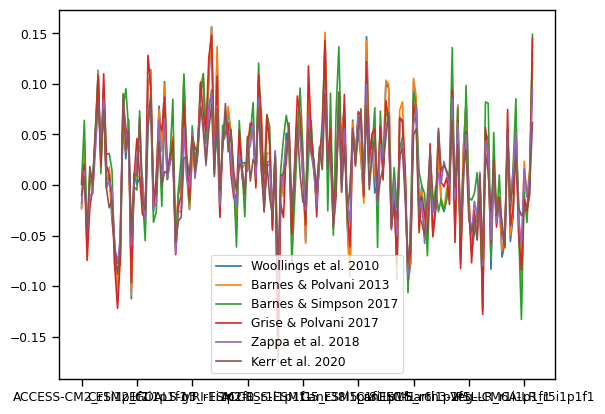

In [53]:
hist_djf_jet_lat_trend_df.plot();

## .. for CMIP6 SSP5-8.5

In [54]:
%%time
## takes ~4 minutes on Intel i7-10750 
ssp585_djf_jet_lat_mean_dict = {}
ssp585_mam_jet_lat_mean_dict = {}
ssp585_jja_jet_lat_mean_dict = {}
ssp585_son_jet_lat_mean_dict = {}

ssp585_djf_jet_lat_trend_dict = {}
ssp585_mam_jet_lat_trend_dict = {}
ssp585_jja_jet_lat_trend_dict = {}
ssp585_son_jet_lat_trend_dict = {}

for metric in metric_names:
    print(metric)
    if metric == "Bracegirdle et al. 2018":
        ## ignore because only calculated by annual scale
        continue
    ssp585_djf_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([12, 1, 2])].mean()
    # ssp585_mam_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([3, 4, 5])].mean()
    # ssp585_jja_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([6, 7, 8])].mean()
    ssp585_son_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([9, 10, 11])].mean()
    
    ssp585_djf_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([12, 1, 2])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    # ssp585_mam_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([3, 4, 5])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    # ssp585_jja_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([6, 7, 8])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    ssp585_son_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([9, 10, 11])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)

Woollings et al. 2010


/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])


Barnes & Polvani 2013


/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])


Barnes & Simpson 2017


/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])


Grise & Polvani 2017


/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])


Bracegirdle et al. 2018
Zappa et al. 2018


/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])


Kerr et al. 2020


/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_12711/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])


CPU times: user 12min 37s, sys: 472 ms, total: 12min 37s
Wall time: 12min 39s


In [55]:
ssp585_djf_jet_lat_mean_df = pd.concat(ssp585_djf_jet_lat_mean_dict, axis=1)
# ssp585_mam_jet_lat_mean_df = pd.concat(ssp585_mam_jet_lat_mean_dict, axis=1)
# ssp585_jja_jet_lat_mean_df = pd.concat(ssp585_jja_jet_lat_mean_dict, axis=1)
ssp585_son_jet_lat_mean_df = pd.concat(ssp585_son_jet_lat_mean_dict, axis=1)

ssp585_djf_jet_lat_trend_df = pd.concat(ssp585_djf_jet_lat_trend_dict, axis=1)
# ssp585_mam_jet_lat_trend_df = pd.concat(ssp585_mam_jet_lat_trend_dict, axis=1)
# ssp585_jja_jet_lat_trend_df = pd.concat(ssp585_jja_jet_lat_trend_dict, axis=1)
ssp585_son_jet_lat_trend_df = pd.concat(ssp585_son_jet_lat_trend_dict, axis=1)

In [56]:
ssp585_djf_jet_lat_trend_df.head()

,Woollings et al. 2010,Barnes & Polvani 2013,Barnes & Simpson 2017,Grise & Polvani 2017,Zappa et al. 2018,Kerr et al. 2020
CanESM5_r3i1p1f1,-0.004942,-0.006274,0.011759,0.006236,-0.001753,0.016096
CMCC-ESM2_r1i1p1f1,0.101355,0.110416,0.119541,0.096225,0.067462,0.078099
CanESM5_r10i1p2f1,0.082631,0.084627,0.144880,0.038451,0.052307,0.035471
UKESM1-0-LL_r14i1p1f2,-0.033018,-0.030140,-0.043708,-0.017527,-0.006941,-0.006313
CanESM5_r5i1p2f1,0.107703,0.096728,0.136140,0.110759,0.086455,0.071234


<Axes: >

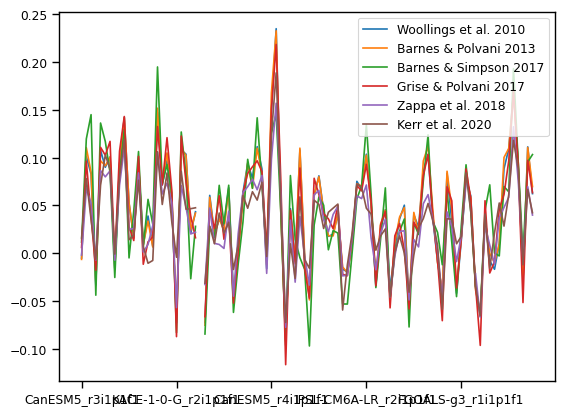

In [57]:
ssp585_djf_jet_lat_trend_df.plot()

# Combine data

In [58]:
all_seasons_rean_jet_lat_mean_and_trend_df = all_seasons_rean_jet_lat_mean_and_trend_df.loc[~(all_seasons_rean_jet_lat_mean_and_trend_df.Metric == "Bracegirdle et al. 2018")]

In [59]:
djf_all_rean_mean = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='DJF Mean')
djf_all_rean_trend = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='DJF Trend_decade')

# mam_all_rean_mean = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='MAM Mean')
# mam_all_rean_trend = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='MAM Trend_decade')

# jja_all_rean_mean = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='JJA Mean')
# jja_all_rean_trend = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='JJA Trend_decade')

son_all_rean_mean = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='SON Mean')
son_all_rean_trend = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='SON Trend_decade')

In [60]:
djf_all_rean_mean

Metric,Barnes & Polvani 2013,Barnes & Simpson 2017,Grise & Polvani 2017,Kerr et al. 2020,Woollings et al. 2010,Zappa et al. 2018
Dataset,,,,,,
ERA-5,38.491300,37.560526,39.262580,40.912466,38.366658,38.185045
JRA-55,38.483448,37.378289,39.184255,40.868328,38.411569,38.294532
MERRA-2,38.545687,37.627632,39.341559,41.368274,38.401064,38.332956
NCEP/DOE II,38.356249,37.348684,38.901179,40.398150,38.296543,38.201884


In [61]:
djf_all_rean_mean = djf_all_rean_mean[sorted(djf_all_rean_mean.columns, key=lambda x: x[-4:])]
djf_all_rean_trend = djf_all_rean_trend[sorted(djf_all_rean_trend.columns, key=lambda x: x[-4:])]

# mam_all_rean_mean = mam_all_rean_mean[sorted(mam_all_rean_mean.columns, key=lambda x: x[-4:])]
# mam_all_rean_trend = mam_all_rean_trend[sorted(mam_all_rean_trend.columns, key=lambda x: x[-4:])]

# jja_all_rean_mean = jja_all_rean_mean[sorted(jja_all_rean_mean.columns, key=lambda x: x[-4:])]
# jja_all_rean_trend = jja_all_rean_trend[sorted(jja_all_rean_trend.columns, key=lambda x: x[-4:])]

son_all_rean_mean = son_all_rean_mean[sorted(son_all_rean_mean.columns, key=lambda x: x[-4:])]
son_all_rean_trend = son_all_rean_trend[sorted(son_all_rean_trend.columns, key=lambda x: x[-4:])]

#### sort index by minimum difference from reanalysis mean across all metrics

In [62]:
sorted_index_by_minimum_error_from_reanalysis_mean_djf = abs(hist_djf_jet_lat_mean_df -  djf_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values().index
sorted_index_by_minimum_error_from_reanalysis_trends_djf = abs(hist_djf_jet_lat_trend_df -  djf_all_rean_trend.mean())\
                                                    .sum(axis=1).sort_values().index

# sorted_index_by_minimum_error_from_reanalysis_mean_mam = abs(hist_mam_jet_lat_mean_df -  mam_all_rean_mean.mean())\
#                                                     .sum(axis=1).sort_values().index
# sorted_index_by_minimum_error_from_reanalysis_trends_mam = abs(hist_mam_jet_lat_trend_df -  mam_all_rean_trend.mean())\
#                                                     .sum(axis=1).sort_values().index

# sorted_index_by_minimum_error_from_reanalysis_mean_jja = abs(hist_jja_jet_lat_mean_df -  jja_all_rean_mean.mean())\
#                                                     .sum(axis=1).sort_values().index
# sorted_index_by_minimum_error_from_reanalysis_trends_jja = abs(hist_jja_jet_lat_trend_df -  jja_all_rean_trend.mean())\
#                                                     .sum(axis=1).sort_values().index

sorted_index_by_minimum_error_from_reanalysis_mean_son = abs(hist_son_jet_lat_mean_df -  son_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values().index
sorted_index_by_minimum_error_from_reanalysis_trends_son = abs(hist_son_jet_lat_trend_df -  son_all_rean_trend.mean())\
                                                    .sum(axis=1).sort_values().index

In [63]:
hist_djf_jet_lat_mean_df = hist_djf_jet_lat_mean_df.loc[sorted_index_by_minimum_error_from_reanalysis_mean_djf]
hist_djf_jet_lat_trend_df = hist_djf_jet_lat_trend_df.loc[sorted_index_by_minimum_error_from_reanalysis_trends_djf]

# hist_mam_jet_lat_mean_df = hist_mam_jet_lat_mean_df.loc[sorted_index_by_minimum_error_from_reanalysis_mean_mam]
# hist_mam_jet_lat_trend_df = hist_mam_jet_lat_trend_df.loc[sorted_index_by_minimum_error_from_reanalysis_trends_mam]

# hist_jja_jet_lat_mean_df = hist_jja_jet_lat_mean_df.loc[sorted_index_by_minimum_error_from_reanalysis_mean_jja]
# hist_jja_jet_lat_trend_df = hist_jja_jet_lat_trend_df.loc[sorted_index_by_minimum_error_from_reanalysis_trends_jja]

hist_son_jet_lat_mean_df = hist_son_jet_lat_mean_df.loc[sorted_index_by_minimum_error_from_reanalysis_mean_son]
hist_son_jet_lat_trend_df = hist_son_jet_lat_trend_df.loc[sorted_index_by_minimum_error_from_reanalysis_trends_son]

#### join to reanalysis

In [64]:
djf_hist_and_rean_mean = pd.concat([djf_all_rean_mean, hist_djf_jet_lat_mean_df])
djf_hist_and_rean_trend = pd.concat([djf_all_rean_trend, hist_djf_jet_lat_trend_df])

# mam_hist_and_rean_mean = pd.concat([mam_all_rean_mean, hist_mam_jet_lat_mean_df])
# mam_hist_and_rean_trend = pd.concat([mam_all_rean_trend, hist_mam_jet_lat_trend_df])

# jja_hist_and_rean_mean = pd.concat([jja_all_rean_mean, hist_jja_jet_lat_mean_df])
# jja_hist_and_rean_trend = pd.concat([jja_all_rean_trend, hist_jja_jet_lat_trend_df])

son_hist_and_rean_mean = pd.concat([son_all_rean_mean, hist_son_jet_lat_mean_df])
son_hist_and_rean_trend = pd.concat([son_all_rean_trend, hist_son_jet_lat_trend_df])


### join to ssp585

In [65]:
djf_hist_rean_and_future_mean = pd.concat([djf_hist_and_rean_mean, ssp585_djf_jet_lat_mean_df], axis=1)
djf_hist_rean_and_future_trend = pd.concat([djf_hist_and_rean_trend, ssp585_djf_jet_lat_trend_df], axis=1)

# mam_hist_rean_and_future_mean = pd.concat([mam_hist_and_rean_mean, ssp585_mam_jet_lat_mean_df], axis=1)
# mam_hist_rean_and_future_trend = pd.concat([mam_hist_and_rean_trend, ssp585_mam_jet_lat_trend_df], axis=1)

# jja_hist_rean_and_future_mean = pd.concat([jja_hist_and_rean_mean, ssp585_jja_jet_lat_mean_df], axis=1)
# jja_hist_rean_and_future_trend = pd.concat([jja_hist_and_rean_trend, ssp585_jja_jet_lat_trend_df], axis=1)

son_hist_rean_and_future_mean = pd.concat([son_hist_and_rean_mean, ssp585_son_jet_lat_mean_df], axis=1)
son_hist_rean_and_future_trend = pd.concat([son_hist_and_rean_trend, ssp585_son_jet_lat_trend_df], axis=1)

In [66]:
djf_hist_and_rean_mean.index

Index(['ERA-5', 'JRA-55', 'MERRA-2', 'NCEP/DOE II', 'TaiESM1_r1i1p1f1',
       'CanESM5_r9i1p1f1', 'NorESM2-LM_r1i1p1f1', 'HadGEM3-GC31-LL_r5i1p1f3',
       'CESM2_r7i1p1f1', 'CESM2-WACCM_r2i1p1f1',
       ...
       'MRI-ESM2-0_r3i1p1f1', 'MRI-ESM2-0_r1i1p1f1', 'MIROC-ES2L_r3i1p1f2',
       'GISS-E2-1-G_r1i1p1f2', 'MIROC-ES2L_r6i1p1f2', 'MIROC-ES2L_r5i1p1f2',
       'MIROC-ES2L_r8i1p1f2', 'MIROC-ES2L_r1i1p1f2', 'MIROC-ES2L_r2i1p1f2',
       'INM-CM4-8_r1i1p1f1'],
      dtype='object', length=168)

<Axes: >

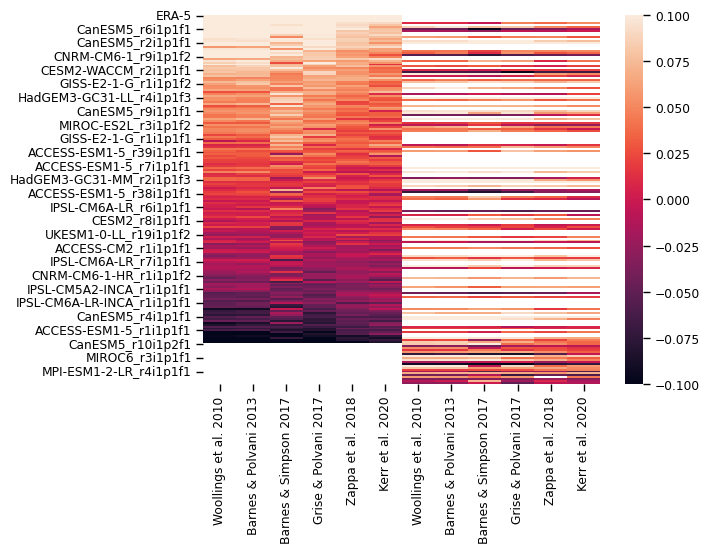

In [67]:
sns.heatmap(djf_hist_rean_and_future_trend)

In [68]:
set(hist_djf_jet_lat_mean_df.index).intersection(set(ssp585_djf_jet_lat_mean_df.index))

{'ACCESS-CM2_r1i1p1f1',
 'ACCESS-ESM1-5_r2i1p1f1',
 'ACCESS-ESM1-5_r3i1p1f1',
 'CESM2-WACCM_r1i1p1f1',
 'CESM2-WACCM_r2i1p1f1',
 'CESM2-WACCM_r3i1p1f1',
 'CMCC-CM2-SR5_r1i1p1f1',
 'CMCC-ESM2_r1i1p1f1',
 'CNRM-CM6-1_r1i1p1f2',
 'CNRM-CM6-1_r2i1p1f2',
 'CNRM-CM6-1_r3i1p1f2',
 'CNRM-CM6-1_r4i1p1f2',
 'CNRM-CM6-1_r5i1p1f2',
 'CNRM-CM6-1_r6i1p1f2',
 'CNRM-ESM2-1_r4i1p1f2',
 'CNRM-ESM2-1_r5i1p1f2',
 'CanESM5_r10i1p1f1',
 'CanESM5_r1i1p1f1',
 'CanESM5_r1i1p2f1',
 'CanESM5_r2i1p1f1',
 'CanESM5_r2i1p2f1',
 'CanESM5_r3i1p1f1',
 'CanESM5_r3i1p2f1',
 'CanESM5_r4i1p1f1',
 'CanESM5_r4i1p2f1',
 'CanESM5_r5i1p1f1',
 'CanESM5_r5i1p2f1',
 'CanESM5_r6i1p1f1',
 'CanESM5_r6i1p2f1',
 'CanESM5_r7i1p1f1',
 'CanESM5_r7i1p2f1',
 'CanESM5_r8i1p1f1',
 'CanESM5_r8i1p2f1',
 'CanESM5_r9i1p1f1',
 'CanESM5_r9i1p2f1',
 'EC-Earth3-CC_r1i1p1f1',
 'EC-Earth3-Veg-LR_r1i1p1f1',
 'EC-Earth3_r1i1p1f1',
 'FGOALS-g3_r1i1p1f1',
 'GFDL-CM4_r1i1p1f1',
 'HadGEM3-GC31-LL_r1i1p1f3',
 'HadGEM3-GC31-LL_r2i1p1f3',
 'HadGEM3-GC31-LL_r3i1

## CMIP6 Future Difference instead of absolute 

In [69]:
for metric in METRIC_NAMES:
    if metric == "Bracegirdle et al. 2018":
        continue
    if metric == "Woollings et al. 2010":
        ## i.e. if first value init the overall dataframe
        metric_future_mean_diff_djf = pd.DataFrame(djf_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
                                          djf_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
        
        metric_future_trend_diff_djf = pd.DataFrame(djf_hist_rean_and_future_trend[metric].diff(axis=1).values[::,1],\
                                          djf_hist_rean_and_future_trend[metric].index, columns=[metric+"_diff"])
        
#         metric_future_mean_diff_mam = pd.DataFrame(mam_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
#                                           mam_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
        
#         metric_future_mean_diff_jja = pd.DataFrame(jja_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
                                          # jja_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
        
        metric_future_mean_diff_son = pd.DataFrame(son_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
                                          son_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
        
        continue
    current_data_mean_djf = pd.DataFrame(djf_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
                                          djf_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
    
    current_data_trends_djf = pd.DataFrame(djf_hist_rean_and_future_trend[metric].diff(axis=1).values[::,1],\
                                          djf_hist_rean_and_future_trend[metric].index, columns=[metric+"_diff"])
    
    metric_future_mean_diff_djf = pd.concat([metric_future_mean_diff_djf, current_data_mean_djf], axis=1)
    metric_future_trend_diff_djf = pd.concat([metric_future_trend_diff_djf, current_data_trends_djf], axis=1)
    
#     current_data_mean_mam = pd.DataFrame(mam_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
#                                           mam_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
#     metric_future_mean_diff_mam = pd.concat([metric_future_mean_diff_mam, current_data_mean_mam], axis=1)

#     current_data_mean_jja = pd.DataFrame(jja_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
#                                           jja_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
#     metric_future_mean_diff_jja = pd.concat([metric_future_mean_diff_jja, current_data_mean_jja], axis=1)

    
    current_data_mean_son = pd.DataFrame(son_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
                                          son_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
    metric_future_mean_diff_son = pd.concat([metric_future_mean_diff_son, current_data_mean_son], axis=1)


In [70]:
mean_diff_data_djf = metric_future_mean_diff_djf.dropna(how='all')
# mean_diff_data_mam = metric_future_mean_diff_mam.dropna(how='all')
# mean_diff_data_jja = metric_future_mean_diff_jja.dropna(how='all')
mean_diff_data_son = metric_future_mean_diff_son.dropna(how='all')

<Axes: >

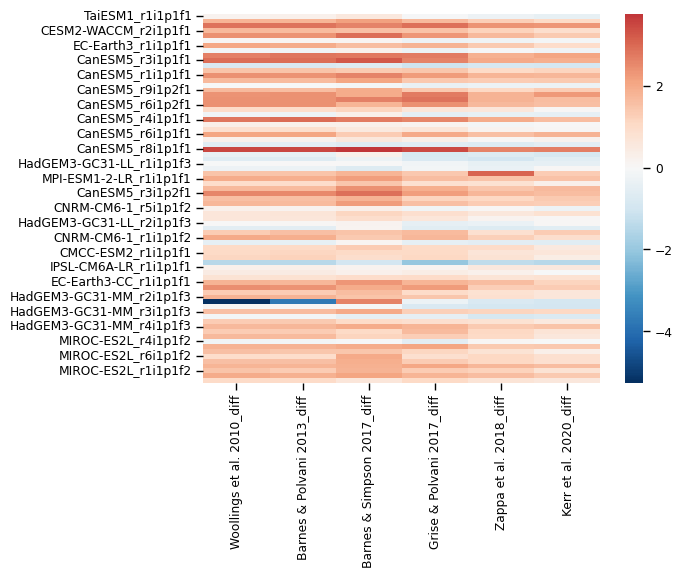

In [71]:
sns.heatmap(mean_diff_data_djf, center=0, cmap='RdBu_r')

In [72]:
# djf_hist_rean_and_future_mean.to_csv('outputs/djf_hist_rean_future_mean.csv')
# djf_hist_rean_and_future_trend.to_csv('outputs/djf_hist_rean_future_trend.csv')

# mam_hist_rean_and_future_mean.to_csv('outputs/mam_hist_rean_future_mean.csv')
# mam_hist_rean_and_future_trend.to_csv('outputs/mam_hist_rean_future_trend.csv')

# jja_hist_rean_and_future_mean.to_csv('outputs/jja_hist_rean_future_mean.csv')
# jja_hist_rean_and_future_trend.to_csv('outputs/jja_hist_rean_future_trend.csv')

# son_hist_rean_and_future_mean.to_csv('outputs/son_hist_rean_future_mean.csv')
# son_hist_rean_and_future_trend.to_csv('outputs/son_hist_rean_future_trend.csv')

In [73]:
# pd.read_csv('outputs/djf_hist_rean_future_mean.csv')

# Make Figure 4

In [74]:
djf_hist_and_future_mean_diffs = metric_future_mean_diff_djf[metric_future_mean_diff_djf.columns[-6:]].iloc[4:]
djf_hist_and_future_mean_diffs_w_mean = pd.concat([djf_hist_and_future_mean_diffs.mean(axis=1), djf_hist_and_future_mean_diffs], axis=1)
djf_hist_and_future_mean_diffs_w_mean.columns = ["Mean", "Woollings et al. 2010", "Barnes & Polvani 2013",\
                                                    "Barnes & Simpson 2017", "Grise & Polvani 2017",\
                                                   "Zappa et al. 2018", "Kerr et al. 2020"] # "Barnes & Polvani 2015",
djf_hist_and_future_mean_diffs_w_mean = djf_hist_and_future_mean_diffs_w_mean.dropna() 


# mam_hist_and_future_mean_diffs = metric_future_mean_diff_mam[metric_future_mean_diff_mam.columns[-6:]].iloc[4:]
# mam_hist_and_future_mean_diffs_w_mean = pd.concat([mam_hist_and_future_mean_diffs.mean(axis=1), mam_hist_and_future_mean_diffs], axis=1)
# mam_hist_and_future_mean_diffs_w_mean.columns = ["Mean", "Woollings et al. 2010", "Barnes & Polvani 2013",\
#                                                     "Barnes & Simpson 2017", "Grise & Polvani 2017",\
#                                                    "Zappa et al. 2018", "Kerr et al. 2020"] # "Barnes & Polvani 2015",
# mam_hist_and_future_mean_diffs_w_mean = mam_hist_and_future_mean_diffs_w_mean.dropna() 



# jja_hist_and_future_mean_diffs = metric_future_mean_diff_jja[metric_future_mean_diff_jja.columns[-6:]].iloc[4:]
# jja_hist_and_future_mean_diffs_w_mean = pd.concat([jja_hist_and_future_mean_diffs.mean(axis=1), jja_hist_and_future_mean_diffs], axis=1)
# jja_hist_and_future_mean_diffs_w_mean.columns = ["Mean", "Woollings et al. 2010", "Barnes & Polvani 2013",\
#                                                     "Barnes & Simpson 2017", "Grise & Polvani 2017",\
#                                                    "Zappa et al. 2018", "Kerr et al. 2020"] # "Barnes & Polvani 2015",
# jja_hist_and_future_mean_diffs_w_mean = jja_hist_and_future_mean_diffs_w_mean.dropna() 



son_hist_and_future_mean_diffs = metric_future_mean_diff_son[metric_future_mean_diff_son.columns[-6:]].iloc[4:]
son_hist_and_future_mean_diffs_w_mean = pd.concat([son_hist_and_future_mean_diffs.mean(axis=1), son_hist_and_future_mean_diffs], axis=1)
son_hist_and_future_mean_diffs_w_mean.columns = ["Mean", "Woollings et al. 2010", "Barnes & Polvani 2013",\
                                                    "Barnes & Simpson 2017", "Grise & Polvani 2017",\
                                                   "Zappa et al. 2018", "Kerr et al. 2020"] # "Barnes & Polvani 2015",
son_hist_and_future_mean_diffs_w_mean = son_hist_and_future_mean_diffs_w_mean.dropna() 




In [75]:
djf_hist_and_future_mean_diffs_w_mean.head()

,Mean,Woollings et al. 2010,Barnes & Polvani 2013,Barnes & Simpson 2017,Grise & Polvani 2017,Zappa et al. 2018,Kerr et al. 2020
TaiESM1_r1i1p1f1,0.030186,0.167013,0.238674,0.541022,-0.058241,-0.286828,-0.420526
CanESM5_r9i1p1f1,1.619355,1.777854,1.752677,2.139407,1.694493,1.278761,1.072939
NorESM2-LM_r1i1p1f1,2.661092,2.874520,2.878904,2.603481,2.908811,2.377864,2.322970
CESM2-WACCM_r2i1p1f1,1.431093,1.705213,1.669646,1.588222,1.507207,1.200596,0.915673
CanESM5_r4i1p2f1,2.183704,2.402060,2.377774,2.935233,2.306144,1.706394,1.374619


In [76]:
djf_hist_and_future_trend_diffs = metric_future_trend_diff_djf[metric_future_trend_diff_djf.columns[-6:]].iloc[4:]
djf_hist_and_future_trend_diffs_w_mean = pd.concat([djf_hist_and_future_trend_diffs.mean(axis=1), djf_hist_and_future_trend_diffs], axis=1)
djf_hist_and_future_trend_diffs_w_mean.columns = ["Mean", "Woollings et al. 2010", "Barnes & Polvani 2013",\
                                                    "Barnes & Simpson 2017", "Grise & Polvani 2017",\
                                                   "Zappa et al. 2018", "Kerr et al. 2020"] # "Barnes & Polvani 2015",
djf_hist_and_future_trend_diffs_w_mean = djf_hist_and_future_trend_diffs_w_mean.dropna()
djf_hist_and_future_trend_diffs_w_mean.head()

,Mean,Woollings et al. 2010,Barnes & Polvani 2013,Barnes & Simpson 2017,Grise & Polvani 2017,Zappa et al. 2018,Kerr et al. 2020
CanESM5_r2i1p2f1,-0.101070,-0.134661,-0.141421,-0.139467,-0.096540,-0.056528,-0.037801
UKESM1-0-LL_r15i1p1f2,-0.045602,-0.035039,-0.033649,-0.073248,-0.063718,-0.042226,-0.025734
CanESM5_r6i1p1f1,-0.163894,-0.191963,-0.191547,-0.205103,-0.168742,-0.132539,-0.093472
CNRM-CM6-1_r4i1p1f2,-0.112480,-0.129464,-0.128232,-0.134529,-0.112788,-0.087218,-0.082650
MIROC-ES2L_r6i1p1f2,-0.051690,-0.068846,-0.078402,-0.022401,-0.061975,-0.030812,-0.047705


In [77]:
djf_hist_and_future_mean_diffs_w_mean_ensemble_means = djf_hist_and_future_mean_diffs_w_mean.groupby(lambda row: row.split('_')[0]).mean()
djf_hist_and_future_trend_diffs_w_mean_ensemble_means = djf_hist_and_future_trend_diffs_w_mean.groupby(lambda row: row.split('_')[0]).mean()

# mam_hist_and_future_mean_diffs_w_mean_ensemble_means = mam_hist_and_future_mean_diffs_w_mean.groupby(lambda row: row.split('_')[0]).mean()

# jja_hist_and_future_mean_diffs_w_mean_ensemble_means = jja_hist_and_future_mean_diffs_w_mean.groupby(lambda row: row.split('_')[0]).mean()

son_hist_and_future_mean_diffs_w_mean_ensemble_means = son_hist_and_future_mean_diffs_w_mean.groupby(lambda row: row.split('_')[0]).mean()


In [78]:
## find closest to reanalysis ensemble mean
djf_index_only_projs_for_sorting = djf_hist_rean_and_future_mean.dropna(how='any', axis=0).index
djf_hist_where_proj_also_vals = hist_djf_jet_lat_mean_df.loc[djf_index_only_projs_for_sorting]

# mam_index_only_projs_for_sorting = mam_hist_rean_and_future_mean.dropna(how='any', axis=0).index
# mam_hist_where_proj_also_vals = hist_mam_jet_lat_mean_df.loc[mam_index_only_projs_for_sorting]

# jja_index_only_projs_for_sorting = jja_hist_rean_and_future_mean.dropna(how='any', axis=0).index
# jja_hist_where_proj_also_vals = hist_jja_jet_lat_mean_df.loc[jja_index_only_projs_for_sorting]

son_index_only_projs_for_sorting = son_hist_rean_and_future_mean.dropna(how='any', axis=0).index
son_hist_where_proj_also_vals = hist_son_jet_lat_mean_df.loc[son_index_only_projs_for_sorting]

In [79]:
djf_hist_where_proj_also_vals_ens_means = djf_hist_where_proj_also_vals.groupby(lambda row: row.split('_')[0]).mean()

# mam_hist_where_proj_also_vals_ens_means = mam_hist_where_proj_also_vals.groupby(lambda row: row.split('_')[0]).mean()

# jja_hist_where_proj_also_vals_ens_means = jja_hist_where_proj_also_vals.groupby(lambda row: row.split('_')[0]).mean()

son_hist_where_proj_also_vals_ens_means = son_hist_where_proj_also_vals.groupby(lambda row: row.split('_')[0]).mean()

In [395]:
abs(djf_hist_where_proj_also_vals_ens_means -  djf_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values()

TaiESM1              0.743316
NorESM2-LM           0.972849
CanESM5              1.201056
EC-Earth3            1.207518
KACE-1-0-G           1.219136
CESM2-WACCM          1.467534
CNRM-ESM2-1          1.742749
ACCESS-ESM1-5        2.455091
HadGEM3-GC31-LL      2.575936
NorESM2-MM           2.904361
MPI-ESM1-2-LR        2.929171
EC-Earth3-Veg-LR     3.101071
UKESM1-0-LL          3.865565
CNRM-CM6-1           4.368021
MPI-ESM1-2-HR        6.115426
CMCC-ESM2            6.413295
ACCESS-CM2           7.335936
INM-CM5-0            7.854855
EC-Earth3-CC         7.893677
CMCC-CM2-SR5         8.053884
NESM3                8.733660
HadGEM3-GC31-MM      9.681487
IPSL-CM6A-LR        10.330175
FGOALS-g3           10.702884
GFDL-CM4            11.240548
MIROC6              15.295527
MRI-ESM2-0          19.416953
MIROC-ES2L          21.041905
INM-CM4-8           24.988869
dtype: float64

In [80]:
sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf = abs(djf_hist_where_proj_also_vals_ens_means -  djf_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values().index

# sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_mam = abs(mam_hist_where_proj_also_vals_ens_means -  mam_all_rean_mean.mean())\
#                                                     .sum(axis=1).sort_values().index

# sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_jja = abs(jja_hist_where_proj_also_vals_ens_means -  jja_all_rean_mean.mean())\
#                                                     .sum(axis=1).sort_values().index

sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_son = abs(son_hist_where_proj_also_vals_ens_means -  son_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values().index

In [81]:
sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf

Index(['TaiESM1', 'NorESM2-LM', 'CanESM5', 'EC-Earth3', 'KACE-1-0-G',
       'CESM2-WACCM', 'CNRM-ESM2-1', 'ACCESS-ESM1-5', 'HadGEM3-GC31-LL',
       'NorESM2-MM', 'MPI-ESM1-2-LR', 'EC-Earth3-Veg-LR', 'UKESM1-0-LL',
       'CNRM-CM6-1', 'MPI-ESM1-2-HR', 'CMCC-ESM2', 'ACCESS-CM2', 'INM-CM5-0',
       'EC-Earth3-CC', 'CMCC-CM2-SR5', 'NESM3', 'HadGEM3-GC31-MM',
       'IPSL-CM6A-LR', 'FGOALS-g3', 'GFDL-CM4', 'MIROC6', 'MRI-ESM2-0',
       'MIROC-ES2L', 'INM-CM4-8'],
      dtype='object')

In [232]:
df_hist_season_by_cmip6_model_cmip6data = pd.concat([hist_djf_jet_lat_mean_df.mean(axis=1), hist_mam_jet_lat_mean_df.mean(axis=1),\
           hist_jja_jet_lat_mean_df.mean(axis=1), hist_son_jet_lat_mean_df.mean(axis=1)], axis=1)

df_hist_season_by_metric_cmip6data = pd.concat([hist_djf_jet_lat_mean_df.mean(axis=0), hist_mam_jet_lat_mean_df.mean(axis=0),\
           hist_jja_jet_lat_mean_df.mean(axis=0), hist_son_jet_lat_mean_df.mean(axis=0)], axis=1)


df_future_season_by_cmip6_model_cmip6data = pd.concat([ssp585_djf_jet_lat_mean_df.mean(axis=1), ssp585_mam_jet_lat_mean_df.mean(axis=1),\
           ssp585_jja_jet_lat_mean_df.mean(axis=1), ssp585_son_jet_lat_mean_df.mean(axis=1)], axis=1)

df_future_season_by_metric_cmip6data = pd.concat([ssp585_djf_jet_lat_mean_df.mean(axis=0), ssp585_mam_jet_lat_mean_df.mean(axis=0),\
           ssp585_jja_jet_lat_mean_df.mean(axis=0), ssp585_son_jet_lat_mean_df.mean(axis=0)], axis=1)


df_future_hist_diff_season_by_model = df_future_season_by_cmip6_model_cmip6data - df_hist_season_by_cmip6_model_cmip6data
df_future_hist_diff_season_by_metric = df_future_season_by_metric_cmip6data - df_hist_season_by_metric_cmip6data


# df_future_hist_diff_season_by_model = pd.concat([df_future_hist_diff_season_by_model.mean(axis=1), df_future_hist_diff_season_by_model], axis=1)
# df_future_hist_diff_season_by_metric = pd.concat([df_future_hist_diff_season_by_metric.mean(axis=1), df_future_hist_diff_season_by_metric], axis=1)

df_future_hist_diff_season_by_model.columns = ['DJF', 'MAM', 'JJA', 'SON']
df_future_hist_diff_season_by_metric.columns = ['DJF', 'MAM', 'JJA', 'SON']


In [233]:
df_diff_djf = ssp585_djf_jet_lat_mean_df - hist_djf_jet_lat_mean_df 
# df_diff_mam = ssp585_mam_jet_lat_mean_df - hist_mam_jet_lat_mean_df
# df_diff_jja = ssp585_jja_jet_lat_mean_df - hist_jja_jet_lat_mean_df
df_diff_son = ssp585_son_jet_lat_mean_df - hist_son_jet_lat_mean_df

In [234]:
df_future_hist_diff_season_by_model['Annual Mean'] = df_future_hist_diff_season_by_model.mean(axis=1)
df_future_hist_diff_season_by_metric['Annual Mean'] = df_future_hist_diff_season_by_metric.mean(axis=1)

In [235]:
df_diff_djf[df_diff_djf.index.str.contains('CNRM-ESM2-1')].index

Index(['CNRM-ESM2-1_r1i1p1f2', 'CNRM-ESM2-1_r2i1p1f2', 'CNRM-ESM2-1_r3i1p1f2',
       'CNRM-ESM2-1_r4i1p1f2', 'CNRM-ESM2-1_r5i1p1f2'],
      dtype='object')

In [237]:
df_diff_djf_ens_mean = df_diff_djf.groupby(lambda row: row.split('_')[0]).mean()
# df_diff_mam_ens_mean = df_diff_mam.groupby(lambda row: row.split('_')[0]).mean()
# df_diff_jja_ens_mean = df_diff_jja.groupby(lambda row: row.split('_')[0]).mean()
df_diff_son_ens_mean = df_diff_son.groupby(lambda row: row.split('_')[0]).mean()

df_diff_djf_ens_first = df_diff_djf.dropna(how='all')[~df_diff_djf.dropna(how='all').index.str.contains('r10')].groupby(lambda row: row.split('_')[0]).first()
# df_diff_mam_ens_first = df_diff_mam.dropna(how='all')[~df_diff_mam.dropna(how='all').index.str.contains('r10')].groupby(lambda row: row.split('_')[0]).first()
# df_diff_jja_ens_first = df_diff_jja.dropna(how='all')[~df_diff_jja.dropna(how='all').index.str.contains('r10')].groupby(lambda row: row.split('_')[0]).first()
df_diff_son_ens_first = df_diff_son.dropna(how='all')[~df_diff_son.dropna(how='all').index.str.contains('r10')].groupby(lambda row: row.split('_')[0]).first()

df_diff_djf_ens_median = df_diff_djf.groupby(lambda row: row.split('_')[0]).median()
# df_diff_mam_ens_median = df_diff_mam.groupby(lambda row: row.split('_')[0]).median()
# df_diff_jja_ens_median = df_diff_jja.groupby(lambda row: row.split('_')[0]).median()
df_diff_son_ens_median = df_diff_son.groupby(lambda row: row.split('_')[0]).median()

In [238]:
models_in_groups_in_future_djf = [model for model in df_diff_djf.dropna().index if model.split('_')[0] in sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf]
model_realisation_counts_djf = collections.Counter([model_name.split('_')[0] for model_name in models_in_groups_in_future_djf])

# models_in_groups_in_future_mam = [model for model in df_diff_mam.dropna().index if model.split('_')[0] in sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_mam]
# model_realisation_counts_mam = collections.Counter([model_name.split('_')[0] for model_name in models_in_groups_in_future_mam])

# models_in_groups_in_future_jja = [model for model in df_diff_jja.dropna().index if model.split('_')[0] in sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_jja]
# model_realisation_counts_jja = collections.Counter([model_name.split('_')[0] for model_name in models_in_groups_in_future_jja])

models_in_groups_in_future_son = [model for model in df_diff_son.dropna().index if model.split('_')[0] in sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_son]
model_realisation_counts_son = collections.Counter([model_name.split('_')[0] for model_name in models_in_groups_in_future_son])

In [239]:
model_realisation_counts_djf

Counter({'CanESM5': 19,
         'MIROC-ES2L': 7,
         'CNRM-CM6-1': 6,
         'UKESM1-0-LL': 6,
         'HadGEM3-GC31-LL': 4,
         'HadGEM3-GC31-MM': 4,
         'CESM2-WACCM': 3,
         'IPSL-CM6A-LR': 3,
         'ACCESS-ESM1-5': 2,
         'CNRM-ESM2-1': 2,
         'ACCESS-CM2': 1,
         'CMCC-CM2-SR5': 1,
         'CMCC-ESM2': 1,
         'EC-Earth3-CC': 1,
         'EC-Earth3-Veg-LR': 1,
         'EC-Earth3': 1,
         'FGOALS-g3': 1,
         'GFDL-CM4': 1,
         'INM-CM4-8': 1,
         'INM-CM5-0': 1,
         'KACE-1-0-G': 1,
         'MIROC6': 1,
         'MPI-ESM1-2-HR': 1,
         'MPI-ESM1-2-LR': 1,
         'MRI-ESM2-0': 1,
         'NorESM2-LM': 1,
         'NorESM2-MM': 1,
         'TaiESM1': 1})

In [240]:
models_in_groups_in_future_djf

['ACCESS-CM2_r1i1p1f1',
 'ACCESS-ESM1-5_r2i1p1f1',
 'ACCESS-ESM1-5_r3i1p1f1',
 'CESM2-WACCM_r1i1p1f1',
 'CESM2-WACCM_r2i1p1f1',
 'CESM2-WACCM_r3i1p1f1',
 'CMCC-CM2-SR5_r1i1p1f1',
 'CMCC-ESM2_r1i1p1f1',
 'CNRM-CM6-1_r1i1p1f2',
 'CNRM-CM6-1_r2i1p1f2',
 'CNRM-CM6-1_r3i1p1f2',
 'CNRM-CM6-1_r4i1p1f2',
 'CNRM-CM6-1_r5i1p1f2',
 'CNRM-CM6-1_r6i1p1f2',
 'CNRM-ESM2-1_r4i1p1f2',
 'CNRM-ESM2-1_r5i1p1f2',
 'CanESM5_r10i1p1f1',
 'CanESM5_r1i1p1f1',
 'CanESM5_r1i1p2f1',
 'CanESM5_r2i1p1f1',
 'CanESM5_r2i1p2f1',
 'CanESM5_r3i1p1f1',
 'CanESM5_r3i1p2f1',
 'CanESM5_r4i1p1f1',
 'CanESM5_r4i1p2f1',
 'CanESM5_r5i1p1f1',
 'CanESM5_r5i1p2f1',
 'CanESM5_r6i1p1f1',
 'CanESM5_r6i1p2f1',
 'CanESM5_r7i1p1f1',
 'CanESM5_r7i1p2f1',
 'CanESM5_r8i1p1f1',
 'CanESM5_r8i1p2f1',
 'CanESM5_r9i1p1f1',
 'CanESM5_r9i1p2f1',
 'EC-Earth3-CC_r1i1p1f1',
 'EC-Earth3-Veg-LR_r1i1p1f1',
 'EC-Earth3_r1i1p1f1',
 'FGOALS-g3_r1i1p1f1',
 'GFDL-CM4_r1i1p1f1',
 'HadGEM3-GC31-LL_r1i1p1f3',
 'HadGEM3-GC31-LL_r2i1p1f3',
 'HadGEM3-GC31-LL_r3i1

In [313]:
multi_r_models_djf = pd.DataFrame()
# multi_r_models_mam = pd.DataFrame()
# multi_r_models_jja = pd.DataFrame()
multi_r_models_son = pd.DataFrame()

counter = 0
for model_name in model_realisation_counts_djf.keys():
    if model_realisation_counts_djf[model_name] > 1 and model_name in sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf:
        # print(model_name,  model_realisation_counts[model_name])
        all_models_in_group_djf = df_diff_djf.loc[df_diff_djf.index.str.startswith(model_name)].dropna()
        # all_models_in_group_mam = df_diff_mam.loc[df_diff_mam.index.str.startswith(model_name)].dropna()
        # all_models_in_group_jja = df_diff_jja.loc[df_diff_jja.index.str.startswith(model_name)].dropna()
        all_models_in_group_son = df_diff_son.loc[df_diff_son.index.str.startswith(model_name)].dropna()

        if counter == 0:
            multi_r_models_djf[model_name] = all_models_in_group_djf.values.flatten() # old: .values.flatten()
            # multi_r_models_mam[model_name] = all_models_in_group_mam.values.flatten()
            # multi_r_models_jja[model_name] = all_models_in_group_jja.values.flatten()
            multi_r_models_son[model_name] = all_models_in_group_son.values.flatten() #.median(axis=1).values
        else:
            current_mgroup_djf = pd.Series(all_models_in_group_djf.values.flatten() , name=model_name)
            multi_r_models_djf = pd.concat([multi_r_models_djf, current_mgroup_djf], axis=1)
            
#             current_mgroup_mam = pd.Series(all_models_in_group_mam.values.flatten(), name=model_name)
#             multi_r_models_mam = pd.concat([multi_r_models_mam, current_mgroup_mam], axis=1)
            
#             current_mgroup_jja = pd.Series(all_models_in_group_jja.values.flatten(), name=model_name)
#             multi_r_models_jja = pd.concat([multi_r_models_jja, current_mgroup_jja], axis=1)
            
            current_mgroup_son = pd.Series(all_models_in_group_son.values.flatten(), name=model_name)
            multi_r_models_son = pd.concat([multi_r_models_son, current_mgroup_son], axis=1)
        counter+=1
    

In [314]:
multi_r_models_djf.head()

,ACCESS-ESM1-5,CESM2-WACCM,CNRM-CM6-1,CNRM-ESM2-1,CanESM5,HadGEM3-GC31-LL,HadGEM3-GC31-MM,IPSL-CM6A-LR,MIROC-ES2L,UKESM1-0-LL
0,-0.602643,0.869725,1.995679,0.064595,2.634396,-0.020214,1.341278,0.265404,1.470211,-0.037256
1,-0.536366,0.914458,1.922337,0.092876,2.786439,-0.004519,1.336470,0.290777,1.354102,-0.037488
2,-0.667853,0.513141,1.389691,0.116126,2.759530,0.009259,1.641956,0.191074,1.786480,-0.111111
3,-0.633901,0.684482,1.747739,-0.272675,2.728611,-0.191545,0.990926,0.151297,1.307204,-0.377858
4,-0.708718,0.193365,1.245178,-0.230701,1.874469,-0.404885,0.829989,0.555034,1.197538,-0.320943


In [315]:
## make dataset correct size for plotting
model_name_df_djf = pd.DataFrame(df_diff_djf_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf].T.columns)
model_name_df_djf.index= model_name_df_djf[0]
model_name_df_djf[0] = np.nan
model_name_df_djf = model_name_df_djf.rename(columns={0:'remove_col'})
multi_r_models_w_all_models_djf = pd.concat([model_name_df_djf.T, multi_r_models_djf])
multi_r_models_w_all_models_djf = multi_r_models_w_all_models_djf.drop('remove_col')

# model_name_df_mam = pd.DataFrame(df_diff_mam_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_mam].T.columns)
# model_name_df_mam.index= model_name_df_mam[0]
# model_name_df_mam[0] = np.nan
# model_name_df_mam = model_name_df_mam.rename(columns={0:'remove_col'})
# multi_r_models_w_all_models_mam = pd.concat([model_name_df_mam.T, multi_r_models_mam])
# multi_r_models_w_all_models_mam = multi_r_models_w_all_models_mam.drop('remove_col')

# model_name_df_jja = pd.DataFrame(df_diff_jja_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_jja].T.columns)
# model_name_df_jja.index= model_name_df_jja[0]
# model_name_df_jja[0] = np.nan
# model_name_df_jja = model_name_df_jja.rename(columns={0:'remove_col'})
# multi_r_models_w_all_models_jja = pd.concat([model_name_df_jja.T, multi_r_models_jja])
# multi_r_models_w_all_models_jja = multi_r_models_w_all_models_jja.drop('remove_col')

model_name_df_son = pd.DataFrame(df_diff_son_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_son].T.columns)
model_name_df_son.index= model_name_df_son[0]
model_name_df_son[0] = np.nan
model_name_df_son = model_name_df_son.rename(columns={0:'remove_col'})
multi_r_models_w_all_models_son = pd.concat([model_name_df_son.T, multi_r_models_son])
multi_r_models_w_all_models_son = multi_r_models_w_all_models_son.drop('remove_col')


In [316]:
multi_r_models_w_all_models_son.head()

,CESM2-WACCM,HadGEM3-GC31-MM,CNRM-CM6-1,CNRM-ESM2-1,CMCC-ESM2,INM-CM5-0,EC-Earth3-Veg-LR,UKESM1-0-LL,EC-Earth3-CC,CanESM5,...,MPI-ESM1-2-HR,TaiESM1,MRI-ESM2-0,KACE-1-0-G,ACCESS-ESM1-5,MIROC6,NorESM2-LM,MIROC-ES2L,FGOALS-g3,ACCESS-CM2
0,1.263443,1.399378,2.592142,1.657305,NaN,NaN,NaN,2.256019,NaN,2.074966,...,NaN,NaN,NaN,NaN,2.072344,NaN,NaN,-0.213630,NaN,NaN
1,1.266386,1.407281,2.665600,1.703410,NaN,NaN,NaN,2.173133,NaN,2.019993,...,NaN,NaN,NaN,NaN,2.045568,NaN,NaN,-0.353866,NaN,NaN
2,1.462481,1.220133,2.822051,1.956901,NaN,NaN,NaN,2.083333,NaN,2.180722,...,NaN,NaN,NaN,NaN,2.302390,NaN,NaN,0.287268,NaN,NaN
3,1.260469,1.396670,2.517286,1.821205,NaN,NaN,NaN,2.308926,NaN,2.098670,...,NaN,NaN,NaN,NaN,2.180212,NaN,NaN,-0.790194,NaN,NaN
4,0.826506,1.015746,2.005340,1.660151,NaN,NaN,NaN,1.700568,NaN,1.575219,...,NaN,NaN,NaN,NaN,1.464990,NaN,NaN,0.103674,NaN,NaN


<Axes: >

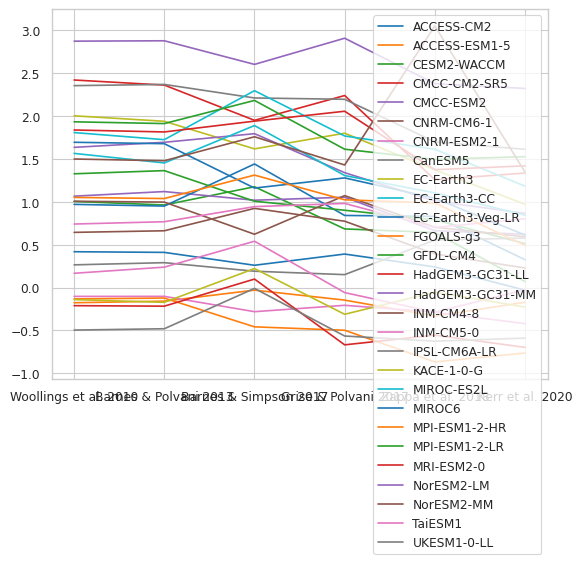

In [317]:
df_diff_djf_ens_median.T.dropna(how='all', axis=1).plot()

/home/thomaskeel/miniconda3/envs/jsanalysis/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


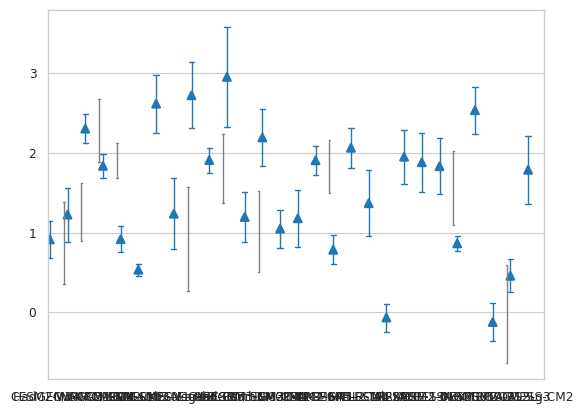

In [318]:
# help from: https://stackoverflow.com/questions/46486934/seaborn-pointplot-and-boxplot-in-one-plot-but-shifted-on-the-x-axis
fig, ax = plt.subplots(1)
estimator_to_use = 'median'
sns.pointplot(df_diff_son_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_son].T, errorbar=('sd', 1),  capsize=.3, estimator=estimator_to_use,\
              markers = '^', errwidth=1, join=False, ax=ax)
offset = matplotlib.transforms.ScaledTranslation(-(5/72.), 0, ax.figure.dpi_scale_trans)
trans = ax.collections[0].get_transform()
ax.collections[0].set_transform(trans + offset)
for line in ax.lines:
    trans = line.get_transform()
    line.set_transform(trans + offset)
    
sns.pointplot(multi_r_models_w_all_models_son, errorbar=('sd', 1),  capsize=.1, estimator=estimator_to_use,\
              markers='', errwidth=1, join=False, color='.5',  ax=ax);

offset = matplotlib.transforms.ScaledTranslation(5/72., 0, ax.figure.dpi_scale_trans)
trans = ax.collections[1].get_transform()
ax.collections[1].set_transform(trans + offset)
for line in ax.lines[len(ax.lines)//2:]:
    trans = line.get_transform()
    line.set_transform(trans + offset)

In [307]:
## DROP PROBLEMATIC NESM1

In [248]:
if 'NESM3' in df_diff_son_ens_mean.index:
    print('dropping NESM3')
    df_diff_djf_ens_mean = df_diff_djf_ens_mean.drop('NESM3')
    df_diff_djf_ens_first = df_diff_djf_ens_first.drop('NESM3')
    df_diff_djf_ens_median = df_diff_djf_ens_median.drop('NESM3')
    df_future_hist_diff_season_by_model = df_future_hist_diff_season_by_model.drop('NESM3_r1i1p1f1')
    df_future_hist_diff_season_by_model = df_future_hist_diff_season_by_model.drop('NESM3_r2i1p1f1')
    djf_hist_and_future_mean_diffs_w_mean_ensemble_means = djf_hist_and_future_mean_diffs_w_mean_ensemble_means.drop('NESM3')
    multi_r_models_w_all_models_djf = multi_r_models_w_all_models_djf.drop('NESM3', axis=1)
    sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf = sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf.drop('NESM3')

#     df_diff_mam_ens_mean = df_diff_mam_ens_mean.drop('NESM3')
#     df_diff_mam_ens_first = df_diff_mam_ens_first.drop('NESM3')
#     mam_hist_and_future_mean_diffs_w_mean_ensemble_means = mam_hist_and_future_mean_diffs_w_mean_ensemble_means.drop('NESM3')
#     multi_r_models_w_all_models_mam = multi_r_models_w_all_models_mam.drop('NESM3', axis=1)
#     sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_mam = sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_mam.drop('NESM3')
    
#     df_diff_jja_ens_mean = df_diff_jja_ens_mean.drop('NESM3')
#     df_diff_jja_ens_first = df_diff_jja_ens_first.drop('NESM3')
#     jja_hist_and_future_mean_diffs_w_mean_ensemble_means = jja_hist_and_future_mean_diffs_w_mean_ensemble_means.drop('NESM3')
#     multi_r_models_w_all_models_jja = multi_r_models_w_all_models_jja.drop('NESM3', axis=1)
#     sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_jja = sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_jja.drop('NESM3')
    
    df_diff_son_ens_mean = df_diff_son_ens_mean.drop('NESM3')
    df_diff_son_ens_first = df_diff_son_ens_first.drop('NESM3')
    son_hist_and_future_mean_diffs_w_mean_ensemble_means = son_hist_and_future_mean_diffs_w_mean_ensemble_means.drop('NESM3')
    multi_r_models_w_all_models_son = multi_r_models_w_all_models_son.drop('NESM3', axis=1)
    sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_son = sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_son.drop('NESM3')

In [621]:
median_order_djf = df_diff_djf_ens_mean.median(axis=1).sort_values(ascending=False).dropna()
median_order_son = df_diff_son_ens_mean.median(axis=1).sort_values(ascending=False).dropna()

In [640]:
# add number to each model name column
# df_diff_djf_ens_mean_with_groupcount = df_diff_djf_ens_mean.copy()
sorted_models_with_group_count_djf = []
sorted_models_with_group_count_mam = []
sorted_models_with_group_count_jja = []
sorted_models_with_group_count_son = []

for model_name in median_order_djf.index:
    if model_realisation_counts_djf[model_name] > 1:
        sorted_models_with_group_count_djf.append(f'{model_name} ({model_realisation_counts_djf[model_name]})')
    else:
        sorted_models_with_group_count_djf.append(model_name)
        
        
# for model_name in df_diff_mam_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_mam].index:
#     if model_realisation_counts_mam[model_name] > 1:
#         sorted_models_with_group_count_mam.append(f'{model_name} ({model_realisation_counts_mam[model_name]})')
#     else:
#         sorted_models_with_group_count_mam.append(model_name)
        
        
# for model_name in df_diff_jja_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_jja].index:
#     if model_realisation_counts_jja[model_name] > 1:
#         sorted_models_with_group_count_jja.append(f'{model_name} ({model_realisation_counts_jja[model_name]})')
#     else:
#         sorted_models_with_group_count_jja.append(model_name)
        
        
for model_name in median_order_son.index:
    if model_realisation_counts_son[model_name] > 1:
        sorted_models_with_group_count_son.append(f'{model_name} ({model_realisation_counts_son[model_name]})')
    else:
        sorted_models_with_group_count_son.append(model_name)

In [692]:
## SEASON TO LOOK AT
df_diff_ens_mean = df_diff_djf_ens_median
sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean = sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf
season_hist_and_future_mean_diffs_w_mean_ensemble_means = djf_hist_and_future_mean_diffs_w_mean_ensemble_means
multi_r_models_w_all_models = multi_r_models_w_all_models_djf
sorted_models_with_group_count = sorted_models_with_group_count_djf
color_to_use = 'C0'
season_name = 'djf'

In [693]:
# df_diff_djf_ens_first.to_csv('outputs/1st_realisation_djf.csv')
# df_diff_son_ens_first.to_csv('outputs/1st_realisation_son.csv')

In [694]:
sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean

Index(['TaiESM1', 'NorESM2-LM', 'CanESM5', 'EC-Earth3', 'KACE-1-0-G',
       'CESM2-WACCM', 'CNRM-ESM2-1', 'ACCESS-ESM1-5', 'HadGEM3-GC31-LL',
       'NorESM2-MM', 'MPI-ESM1-2-LR', 'EC-Earth3-Veg-LR', 'UKESM1-0-LL',
       'CNRM-CM6-1', 'MPI-ESM1-2-HR', 'CMCC-ESM2', 'ACCESS-CM2', 'INM-CM5-0',
       'EC-Earth3-CC', 'CMCC-CM2-SR5', 'HadGEM3-GC31-MM', 'IPSL-CM6A-LR',
       'FGOALS-g3', 'GFDL-CM4', 'MIROC6', 'MRI-ESM2-0', 'MIROC-ES2L',
       'INM-CM4-8'],
      dtype='object')

In [695]:
similiarity_scores_djf = (djf_hist_where_proj_also_vals_ens_means - djf_all_rean_mean.mean()).mean(axis=1)[median_order_djf.index]
similiarity_scores_son = (son_hist_where_proj_also_vals_ens_means - son_all_rean_mean.mean()).mean(axis=1)[median_order_son.index]

similiarity_scores_djf

NorESM2-LM          0.097942
CanESM5             0.140163
CMCC-CM2-SR5       -1.342314
MRI-ESM2-0         -3.236159
MPI-ESM1-2-LR      -0.488195
EC-Earth3-CC       -1.315613
EC-Earth3          -0.145052
NorESM2-MM         -0.484060
HadGEM3-GC31-MM    -1.613581
MIROC6             -2.549254
MIROC-ES2L         -3.506984
CMCC-ESM2          -1.068883
MPI-ESM1-2-HR      -1.019238
CESM2-WACCM         0.244589
GFDL-CM4           -1.873425
EC-Earth3-Veg-LR   -0.516845
INM-CM4-8           4.164811
INM-CM5-0           1.309142
CNRM-CM6-1         -0.728004
IPSL-CM6A-LR       -1.721696
ACCESS-CM2         -1.222656
TaiESM1            -0.109164
CNRM-ESM2-1         0.222122
KACE-1-0-G         -0.092722
ACCESS-ESM1-5       0.241944
HadGEM3-GC31-LL    -0.429323
FGOALS-g3          -1.783814
UKESM1-0-LL         0.644261
dtype: float64

In [696]:
similiarity_scores_djf.min(), similiarity_scores_djf.max(), similiarity_scores_son.min(), similiarity_scores_son.max()

(-3.506984154198174, 4.164811417429622, -2.3656751752026914, 1.401690077511739)

In [697]:
rbr_cmap = plt.cm.RdBu_r
# needed to set 0 as middle
norm_djf = matplotlib.colors.Normalize(vmin=-similiarity_scores_djf.max(),  vmax=similiarity_scores_djf.max())
norm_son = matplotlib.colors.Normalize(vmin=similiarity_scores_son.min(),  vmax=abs(similiarity_scores_son.min()))

/tmp/ipykernel_12711/1051117852.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_xticklabels(ticklabs, fontsize=16);


Text(-3.7, 0.38, 'Equatorward')

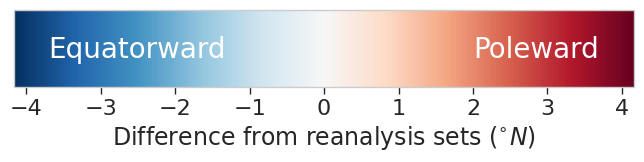

In [698]:
fig, ax = plt.subplots(1, figsize=(8, 1))
# sns.pointplot(df_diff_djf_ens_mean.T[median_order.index], palette=rbr_cmap(norm(similiarity_scores_djf)), capsize=.3, estimator='median', errorbar=errorbar_to_use,\
#               markers = '_', errwidth=1.5, ax=axes[0], join=False);
# ax.figure.colorbar(sm)
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm_djf, cmap=rbr_cmap),
             cax=ax, orientation='horizontal', label='Similarity to Reanalysis')
cbar.ax.set_xlabel('Difference from reanalysis sets $(^{\circ}N)$', size=17)
ticklabs = cbar.ax.get_xticklabels();
cbar.ax.set_xticklabels(ticklabs, fontsize=16);
cbar.ax.text(s="Poleward", x=2, y=0.38, size=20, color='white')
cbar.ax.text(s="Equatorward", x=-3.7, y=0.38, size=20, color='white')
# fig.savefig('figures/figure_4_cbar.png', bbox_inches='tight', dpi=150)

In [699]:
ticklabs

[Text(-5.0, 0, '−5'),
 Text(-4.0, 0, '−4'),
 Text(-3.0, 0, '−3'),
 Text(-2.0, 0, '−2'),
 Text(-1.0, 0, '−1'),
 Text(0.0, 0, '0'),
 Text(1.0, 0, '1'),
 Text(2.0, 0, '2'),
 Text(3.0, 0, '3'),
 Text(4.0, 0, '4'),
 Text(5.0, 0, '5')]

/home/thomaskeel/miniconda3/envs/jsanalysis/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.0, 0.0, 0.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (1.0, 0.4980392156862745, 0.054901960784313725), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/thomaskeel/miniconda3/envs/jsanalysis/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666

Text(-0.6, 3.25, 'DJF')

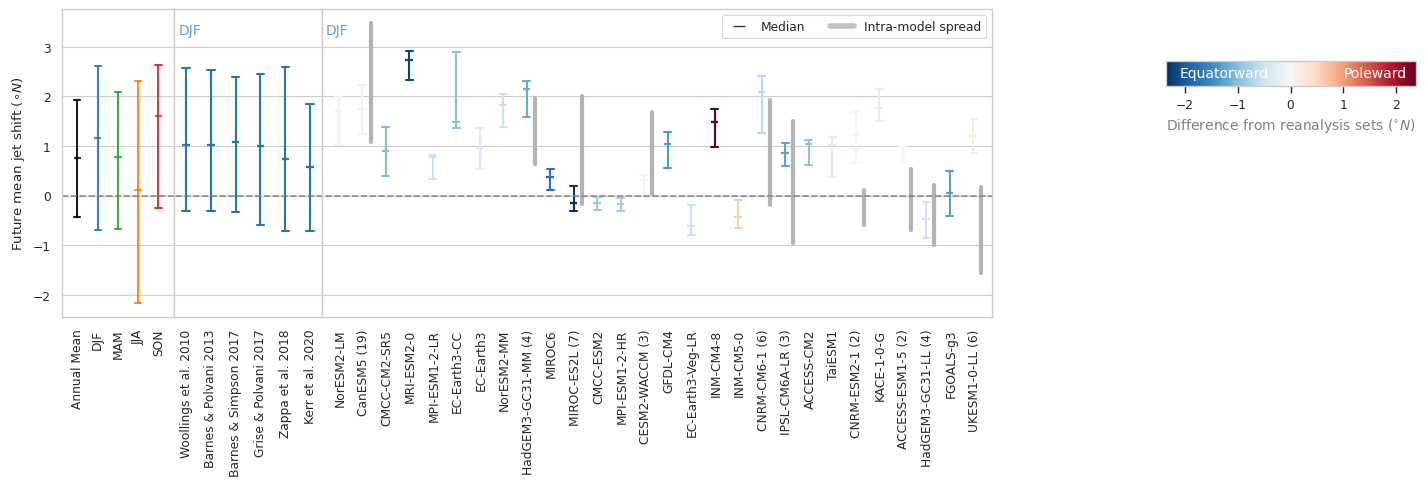

In [701]:
sns.set_context('paper')
sns.set_style('whitegrid')
cols_to_use = ['Woollings et al. 2010', 'Barnes & Polvani 2013', 'Barnes & Simpson 2017', 'Grise & Polvani 2017',\
               'Zappa et al. 2018','Kerr et al. 2020'] # 'Barnes & Polvani 2015'
errorbar_to_use = ('pi', 95)

fig, axes = plt.subplots(1,3, figsize=(12, 4), sharey=True, width_ratios=[0.15, 0.2, 0.9])
plt.subplots_adjust(wspace=0)

sns.pointplot(df_future_hist_diff_season_by_model[["Annual Mean", 'DJF', 'MAM', 'JJA', 'SON']].dropna(), capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '_', errwidth=1.5, join=False, palette=['k', 'C0', 'C2', 'C1', 'C3'], ax=axes[0])
sns.pointplot(df_diff_ens_mean.loc[season_hist_and_future_mean_diffs_w_mean_ensemble_means.index], color=color_to_use, capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '_', errwidth=1.5, join=False, ax=axes[1])
sns.pointplot(df_diff_djf_ens_mean.T[median_order_son.index], palette=rbr_cmap(cmap_norm(similiarity_scores_djf)), capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '_', errwidth=1.5, join=False, ax=axes[2]);
offset = matplotlib.transforms.ScaledTranslation(-(1/72.), 0, axes[2].figure.dpi_scale_trans)
trans = axes[2].collections[0].get_transform()
axes[2].collections[0].set_transform(trans + offset)
for line in axes[2].lines:
    trans = line.get_transform()
    line.set_transform(trans + offset)
    
sns.pointplot(multi_r_models_w_all_models[median_order_djf.index], capsize=.0, estimator='median', errorbar=errorbar_to_use,\
              markers='', errwidth=3, join=False, color='0.7',  ax=axes[2]);

# May not appear in the correct place in the notebook, but necessary for saving
inset_ax2 = inset_axes(axes[2],
                    width=2.5,                     # inch
                    height=0.25,                    # inch
                    bbox_transform=ax.transAxes, # relative axes coordinates
                    bbox_to_anchor=(1.25,0.73),    # relative axes coordinates
                    loc=3)                       # loc=lower left corner
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm_son, cmap=rbr_cmap),
             cax=inset_ax2, orientation='horizontal', label='Similarity to Reanalysis')
cbar.ax.set_xlabel('Difference from reanalysis sets $(^{\circ}N)$', color='grey', size=10)
# ticklabs = cbar.ax.get_xticklabels();
# cbar.ax.set_xticklabels(ticklabs, fontsize=7);
cbar.ax.text(s="Poleward", x=1, y=0.38, size=10, color='white')
cbar.ax.text(s="Equatorward", x=-2.1, y=0.38, size=10, color='white')

offset = matplotlib.transforms.ScaledTranslation(5/72., 0, axes[2].figure.dpi_scale_trans)
trans = axes[2].collections[1].get_transform()
axes[2].collections[1].set_transform(trans + offset)
for line in axes[2].lines[len(axes[2].lines)//2:]:
    trans = line.get_transform()
    line.set_transform(trans + offset)

# for text
lowest_ylim = 100
for ax in axes:
    if ax.get_ylim()[0] < lowest_ylim:
        lowest_ylim = ax.get_ylim()[0]
        
axes[0].set_xticklabels(["Annual Mean", 'DJF', 'MAM', 'JJA', 'SON'], rotation=90);
axes[1].set_xticklabels(cols_to_use, rotation=90);
axes[2].set_xticklabels(sorted_models_with_group_count, rotation=90);
plt.setp(axes[0].collections, alpha=.8); #for the markers
plt.setp(axes[0].lines, alpha=.9);    #for the lines
black_line = mlines.Line2D([], [], color='k', marker='_', linestyle='None',
                          markersize=8, alpha=.8, label='Median')
grey_line = mlines.Line2D([0], [0], color='0.7', linestyle='-', lw=4,
                        alpha=.8, label='Intra-model spread')
axes[2].legend(handles=[black_line, grey_line], ncols=2)
axes[0].hlines(-0, -0.75, 5.5, 'grey', '--', alpha=.9)
axes[1].hlines(-0, -1.5, 7.75, 'grey', '--', alpha=.9)
axes[2].hlines(-0, -1.75, 27.75, 'grey', '--', alpha=.9)
axes[0].set_xlim(-0.75, 4.75)
axes[1].set_xlim(-0.5, 5.5)
axes[2].set_xlim(-0.75, 27.75)

# for ax in axes: # for SON
#     ax.set_ylim(-2.5, 4.1)
# axes[0].spines['right'].set_visible(False)
# axes[1].spines['left'].set_visible(False)
axes[0].set_ylabel("Future mean jet shift (${\circ N}$)")
axes[1].text(s=season_name.upper(), x=-0.3, y=3.25, fontsize=10, alpha=.7, color=color_to_use)
axes[2].text(s=season_name.upper(), x=-0.6, y=3.25, fontsize=10, alpha=.7,  color=color_to_use)
# fig.savefig(f'figures/figure_4_{season_name}.png', bbox_inches='tight', dpi=300)

In [312]:
# multi_r_models_djf.to_csv('outputs/multi_r_models_djf.csv', index=False)
# multi_r_models_mam.to_csv('outputs/multi_r_models_mam.csv', index=False)
# multi_r_models_jja.to_csv('outputs/multi_r_models_jja.csv', index=False)
# multi_r_models_son.to_csv('outputs/multi_r_models_son.csv', index=False)

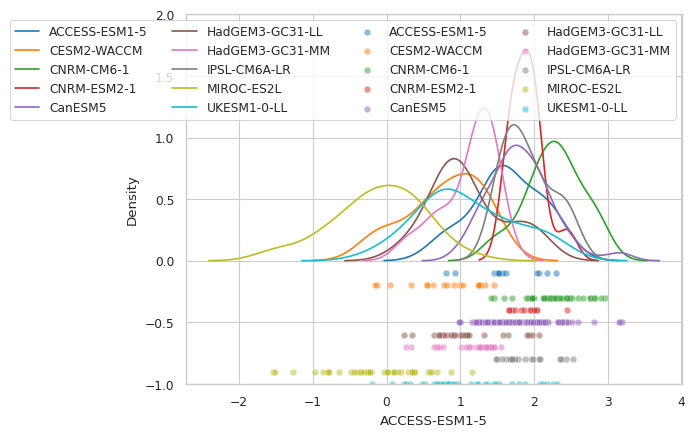

In [102]:
fig, ax = plt.subplots(1) 
for column in multi_r_models_son.columns:
    sns.kdeplot(multi_r_models_son[column], fill=False, label=f'{column}', ax=ax)

y_offset = 0.1
for column in multi_r_models_son.columns:
    sns.scatterplot(x=multi_r_models_son[column], y=np.zeros_like(multi_r_models_son[column])-y_offset, alpha=0.5, label=f'{column}', ax=ax)
    y_offset += 0.1

ax.set_ylim(-1, 2)
plt.legend(ncols=4)


## alternative with ens spread on metric

NameError: name 'models_in_groups_in_future' is not defined

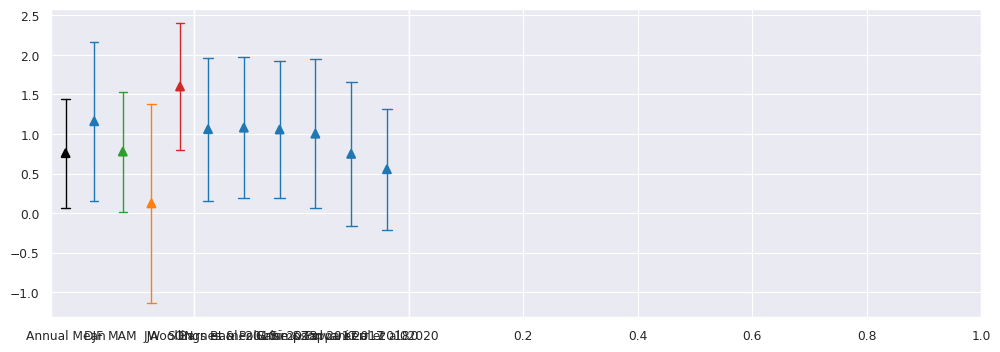

In [202]:
sns.set_context('paper')
sns.set_style('darkgrid')
cols_to_use = ['Woollings et al. 2010', 'Barnes & Polvani 2013', 'Barnes & Simpson 2017', 'Grise & Polvani 2017',\
               'Zappa et al. 2018','Kerr et al. 2020']
errorbar_to_use = ('sd', 1)

fig, axes = plt.subplots(1,3, figsize=(12, 4), sharey=True, width_ratios=[0.2, 0.3, 0.8])
plt.subplots_adjust(wspace=0)

sns.pointplot(df_future_hist_diff_season_by_model[["Annual Mean", 'DJF', 'MAM', 'JJA', 'SON']].dropna(), capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, palette=['k', 'C0', 'C2', 'C1', 'C3'], ax=axes[0])

## BY METRIC
sns.pointplot(df_diff_djf_ens_mean.loc[djf_hist_and_future_mean_diffs_w_mean_ensemble_means.index], capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, ax=axes[1])
offset = matplotlib.transforms.ScaledTranslation(-(3/72.), 0, axes[1].figure.dpi_scale_trans)
trans = axes[1].collections[0].get_transform()
axes[1].collections[0].set_transform(trans + offset)
for line in axes[1].lines:
    trans = line.get_transform()
    line.set_transform(trans + offset)
sns.pointplot(df_diff_djf.loc[models_in_groups_in_future], capsize=.0, estimator='median', errorbar=errorbar_to_use,\
              markers = '', errwidth=2, join=False, color=(0.6, 0.6, 0.6), ax=axes[1])
offset = matplotlib.transforms.ScaledTranslation(3/72., 0, axes[1].figure.dpi_scale_trans)
trans = axes[1].collections[1].get_transform()
axes[1].collections[1].set_transform(trans + offset)
for line in axes[1].lines[len(axes[1].lines)//2:]:
    trans = line.get_transform()
    line.set_transform(trans + offset)

## BY MODEL
sns.pointplot(df_diff_djf_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean].T, capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, ax=axes[2]);
offset = matplotlib.transforms.ScaledTranslation(-(3/72.), 0, axes[2].figure.dpi_scale_trans)
trans = axes[2].collections[0].get_transform()
axes[2].collections[0].set_transform(trans + offset)
for line in axes[2].lines:
    trans = line.get_transform()
    line.set_transform(trans + offset)
    
sns.pointplot(multi_r_models_w_all_models, capsize=.0, estimator='median', errorbar=errorbar_to_use,\
              markers='', errwidth=2, join=False, color=(0.6, 0.6, 0.6),  ax=axes[2]);

offset = matplotlib.transforms.ScaledTranslation(3/72., 0, axes[2].figure.dpi_scale_trans)
trans = axes[2].collections[1].get_transform()
axes[2].collections[1].set_transform(trans + offset)
for line in axes[2].lines[len(axes[2].lines)//2:]:
    trans = line.get_transform()
    line.set_transform(trans + offset)

axes[0].set_xticklabels(["Annual Mean", 'DJF', 'MAM', 'JJA', 'SON'], rotation=90);
axes[1].set_xticklabels(cols_to_use, rotation=90);
axes[2].set_xticklabels(sorted_models_with_group_count, rotation=90);
plt.setp(axes[0].collections, alpha=.8); #for the markers
plt.setp(axes[0].lines, alpha=.9);    #for the lines
axes[2].annotate('', xy=(-1.3, -4.1), xytext=(16, -4.1),
            arrowprops=dict(facecolor='grey', width=4, shrink=0.05), annotation_clip=False)
axes[2].text(s="Similarity to annual mean of reanalysis", x=3.8, y=-4., c='grey', fontsize=10)
black_triangle = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=5, alpha=.8, label='Median')
axes[2].legend(handles=[black_triangle], ncols=2)
axes[0].hlines(-0, -0.75, 5.5, 'grey', '--', alpha=.9)
axes[1].hlines(-0, -1.5, 7.75, 'grey', '--', alpha=.9)
axes[2].hlines(-0, -1.75, 27.75, 'grey', '--', alpha=.9)
axes[0].set_xlim(-0.75, 5.4)
axes[1].set_xlim(-0.5, 7.75)
axes[2].set_xlim(-0.75, 27.75)
axes[0].set_ylim(-1.5, 3.2)
axes[1].set_ylim(-1.5, 3.2)
axes[2].set_ylim(-1.5, 3.2)
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[0].set_ylabel("Future mean jet shift (${\circ N}$)")
axes[2].text(s="SSP5-8.5 vs Historical", x=-0.7, y=-1.4, color='grey', alpha=.8)

# fig.savefig('figures/figure_4_with_ens_spread.png', bbox_inches='tight', dpi=300)

## alternative with no ens mean

In [ ]:
sns.set_context('paper')
sns.set_style('darkgrid')
cols_to_use = ['Woollings et al. 2010', 'Barnes & Polvani 2013', 'Barnes & Simpson 2017', 'Grise & Polvani 2017',\
               'Zappa et al. 2018','Kerr et al. 2020']
errorbar_to_use = ('sd', 1)

fig, axes = plt.subplots(1,3, figsize=(12, 4), sharey=True, width_ratios=[0.2, 0.3, 0.8])
plt.subplots_adjust(wspace=0)

sns.pointplot(df_future_hist_diff_season_by_model[["Annual Mean", 'DJF', 'MAM', 'JJA', 'SON']].dropna(), capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, palette=['k', 'C0', 'C2', 'C1', 'C3'], ax=axes[0])
sns.pointplot(df_diff_djf_ens_mean.loc[djf_hist_and_future_mean_diffs_w_mean_ensemble_means.index], capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, ax=axes[1])
sns.pointplot(df_diff_djf_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean].T, capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, ax=axes[2]);

# sns.pointplot(multi_r_models, errorbar=errorbar_to_use,  capsize=.3, estimator='median',\
#               markers = '^', errwidth=1, join=False, ax=axes[2]);

axes[0].set_xticklabels(["Annual Mean", 'DJF', 'MAM', 'JJA', 'SON'], rotation=90);
axes[1].set_xticklabels(cols_to_use, rotation=90);
axes[2].set_xticklabels(df_diff_djf_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean].index, rotation=90);
plt.setp(axes[0].collections, alpha=.8); #for the markers
plt.setp(axes[0].lines, alpha=.9);    #for the lines
axes[2].annotate('', xy=(-1.3, -4.1), xytext=(16, -4.1),
            arrowprops=dict(facecolor='grey', width=4, shrink=0.05), annotation_clip=False)
axes[2].text(s="Similarity to annual mean of reanalysis", x=3.8, y=-4., c='grey', fontsize=10)
black_triangle = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=5, alpha=.8, label='Median')
axes[2].legend(handles=[black_triangle], ncols=2)
axes[0].hlines(-0, -0.75, 5.5, 'grey', '--', alpha=.9)
axes[1].hlines(-0, -1.5, 7.75, 'grey', '--', alpha=.9)
axes[2].hlines(-0, -1.75, 15.75, 'grey', '--', alpha=.9)
axes[0].set_xlim(-0.75, 5.4)
axes[1].set_xlim(-0.5, 7.75)
axes[2].set_xlim(-0.75, 15.75)
axes[0].set_ylim(-1.5, 3.2)
axes[1].set_ylim(-1.5, 3.2)
axes[2].set_ylim(-1.5, 3.2)
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[0].set_ylabel("Future mean jet shift (${\circ N}$)")
axes[2].text(s="SSP5-8.5 vs Historical", x=-0.7, y=-1.4, color='grey', alpha=.8)

# fig.savefig('figures/figure_4_only_ensmean.png', bbox_inches='tight', dpi=300)

### EXTRA: trend

In [220]:
sns.set_style('darkgrid')
cols_to_use = ['Woollings et al. 2010', 'Barnes & Polvani 2013', 'Barnes & Simpson 2017', 'Grise & Polvani 2017',\
               'Zappa et al. 2018','Kerr et al. 2020']
errorbar_to_use = ('ci', 95)

fig, axes = plt.subplots(1,2, figsize=(7, 4), sharey=True, width_ratios=[0.2, 0.4])
plt.subplots_adjust(wspace=0)
sns.pointplot(djf_hist_and_future_trend_diffs_w_mean_ensemble_means['Mean'], capsize=.15, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1.5, color='k', join=False, ax=axes[0])
sns.pointplot(djf_hist_and_future_trend_diffs_w_mean_ensemble_means[cols_to_use], capsize=.3, estimator='median', errorbar=errorbar_to_use,\
              markers = '^', errwidth=1, join=False, ax=axes[1])
axes[0].scatter("Mean", djf_hist_and_future_trend_diffs_w_mean_ensemble_means["Mean"].mean(), c='k')
axes[1].scatter(cols_to_use, djf_hist_and_future_trend_diffs_w_mean_ensemble_means[cols_to_use].mean())
axes[0].hlines(-0, -0.5, 1.5, 'grey', '-', alpha=.4)
axes[1].hlines(-0, -0.5, 6.5, 'grey', '-', alpha=.4)
# axes[0].set_xlim(-0.4, .4)
# axes[1].set_xlim(-0.5, 6.5)
axes[0].set_ylim(-0.1, .1)
axes[1].set_ylim(-0.1, .1)
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[0].set_xticklabels(["Mean"], rotation=90);
axes[1].set_xticklabels(cols_to_use, rotation=90);
# plt.suptitle('')

black_circle = mlines.Line2D([], [], color='k', marker='o', linestyle='None',
                          markersize=3, alpha=.8, label='Mean')
black_square = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=3, alpha=.8, label='Median')
axes[1].legend(handles=[black_circle, black_square], ncols=2)
axes[0].set_ylabel("Mean latitude (${\circ N}$)")
fig.suptitle("CMIP6 Historical vs CMIP6 SSP5-8.5")
# fig.savefig("figures/summary_figures/cross_metric_vs_by_metric_annual_mean_diff.png", dpi=200, bbox_inches='tight')

Text(0.5, 0.98, 'CMIP6 Historical vs CMIP6 SSP5-8.5')

Error in callback <function _draw_all_if_interactive at 0x7f1aacf36160> (for post_execute):


ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--],
             mask=[ True],
       fill_value=1e+20,
            dtype=float64)

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--],
             mask=[ True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 700x400 with 2 Axes>